# awal

In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import load_model
import random
import os
import joblib
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import time
import json

In [30]:
def atur_seed_deterministik(nilai_seed=42):
    os.environ['PYTHONHASHSEED'] = str(nilai_seed)
    random.seed(nilai_seed)
    np.random.seed(nilai_seed)
    tf.random.set_seed(nilai_seed)
    tf.config.experimental.enable_op_determinism()
atur_seed_deterministik(42)

In [31]:
df = pd.read_csv("bbri.csv")
df["Date"] = pd.to_datetime(df["Date"])
ts = df["Close"]
ts.fillna(method="ffill", inplace=True)
ts.dropna(inplace=True) # Drop any remaining NaNs at the beginning

print(f"--- Data Saham berhasil dibaca ({len(ts)} data poin) ---")
df.set_index('Date', inplace=True)


--- Data Saham berhasil dibaca (2566 data poin) ---


# LSTM

In [4]:
def jalankan_pipeline_lstm(
    df_input,
    target_column='Close',
    time_steps=60,
    train_split_ratio=0.8,
    lstm_units_list=[50, 50],
    dense_units_list=[25],
    dropout_rate=0.2,
    optimizer='adam',
    loss_function='mean_squared_error',
    epochs=50,
    batch_size=32,
    verbose_level=1,
    nama=2,
    show_plots=True
    ):

    print("--- Memulai Pipeline Model LSTM ---")
    data_target = df_input.loc[:, [target_column]]
    dataset = data_target.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    training_data_len = math.ceil(len(dataset) * train_split_ratio)
    train_data_scaled = scaled_data[0:training_data_len, :]
    X_train = []
    y_train = [] 
    for i in range(time_steps, len(train_data_scaled)):
        X_train.append(train_data_scaled[i-time_steps:i, 0])
        y_train.append(train_data_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print(f"Bentuk data latih X_train: {X_train.shape}, y_train (scaled): {y_train.shape}")
    test_data_scaled = scaled_data[training_data_len - time_steps:, :]
    X_test = []
    y_test_actual_unscaled = dataset[training_data_len:, :]

    for i in range(time_steps, len(test_data_scaled)):
        X_test.append(test_data_scaled[i-time_steps:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    # y_test_for_validation adalah target yang diskalakan untuk X_test, digunakan dalam model.fit
    y_test_for_validation = []
    for i in range(time_steps, len(test_data_scaled)):
        y_test_for_validation.append(test_data_scaled[i,0])
    y_test_for_validation = np.array(y_test_for_validation)
    print("Persiapan data selesai.")



    print("\n2. Pembangunan Model LSTM...")
    model = Sequential()
    if len(lstm_units_list) > 1:
        model.add(LSTM(units=lstm_units_list[0], return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(dropout_rate))
        for i in range(1, len(lstm_units_list)):
            is_last_lstm_layer = (i == len(lstm_units_list) - 1)
            model.add(LSTM(units=lstm_units_list[i], return_sequences=not is_last_lstm_layer))
            model.add(Dropout(dropout_rate))
    elif len(lstm_units_list) == 1:
        model.add(LSTM(units=lstm_units_list[0], return_sequences=False, input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(dropout_rate))
    else:
        raise ValueError("lstm_units_list tidak boleh kosong.")
    for units in dense_units_list:
        model.add(Dense(units=units))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss=loss_function)
    print("Ringkasan Model:")
    model.summary()
    print("Model LSTM berhasil dibangun.")

    # 3. Latih Model
    print("\n3. Memulai pelatihan model...")
    start_time = time.time() # Catat waktu mulai
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test_for_validation),
                        verbose=verbose_level)
    end_time = time.time() # Catat waktu selesai
    training_time = end_time - start_time # Hitung durasi
    print("Pelatihan model selesai.")
    print(f"Waktu pelatihan model: {training_time:.2f} detik") # Tampilkan durasi

    # 4. Buat Prediksi
    # Prediksi pada data latih (untuk visualisasi full time)
    print("\n4a. Membuat prediksi pada data latih (untuk visualisasi)...")
    train_predictions_scaled = model.predict(X_train)
    train_predictions_unscaled = scaler.inverse_transform(train_predictions_scaled)

    # Prediksi pada data uji
    print("4b. Membuat prediksi pada data uji...")
    test_predictions_scaled = model.predict(X_test)
    test_predictions_unscaled = scaler.inverse_transform(test_predictions_scaled)
    print("Prediksi selesai.")


    # 5. Evaluasi Model (menggunakan data uji)
    print("\n5. Mengevaluasi model (pada data uji)...")
    rmse = np.sqrt(mean_squared_error(y_test_actual_unscaled, test_predictions_unscaled))
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

    y_test_flat = y_test_actual_unscaled.flatten()
    predictions_flat = test_predictions_unscaled.flatten()
    non_zero_mask = y_test_flat != 0
    if np.any(non_zero_mask):
        mape = mean_absolute_percentage_error(y_test_flat[non_zero_mask], predictions_flat[non_zero_mask]) * 100
        print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    else:
        mape = float('inf')
        print('MAPE tidak dapat dihitung karena semua nilai aktual adalah nol atau tidak ada nilai non-zero.')

    print("\n5b. Menyimpan data untuk visualisasi evaluasi...")

    # 1. Buat DataFrame untuk plot, berisi harga aktual
    df_plot = pd.DataFrame(df_input[target_column])
    df_plot.rename(columns={target_column: 'Harga_Aktual'}, inplace=True)
    test_predict_index = df_input.index[training_data_len : training_data_len + len(test_predictions_unscaled)]
    df_predictions = pd.DataFrame(test_predictions_unscaled, index=test_predict_index, columns=['Prediksi_Uji'])
    df_final_plot = df_plot.join(df_predictions)
    csv_filename = f'LSTM_{nama}_{epochs}.csv'
    df_final_plot.to_csv(csv_filename)
    

    
    # 1. Buat sebuah dictionary untuk menyimpan metrik
    metrik_evaluasi = {
        "RMSE": rmse,
        "MAPE": mape
    }
    json_filename = f'eval_LSTM_{nama}_{epochs}.json'
    with open(json_filename, 'w') as f:
        json.dump(metrik_evaluasi, f, indent=4)
        
    print(f"Metrik evaluasi berhasil disimpan sebagai '{json_filename}'")

    # 6. Visualisasi (Opsional)
    if show_plots:
        print("\n6. Visualisasi Hasil...")


        plt.figure(figsize=(16, 8))
        plt.title(f'Visualisasi Full Time: Harga Aktual vs Prediksi Latih & Uji Saham {target_column}')
        plt.xlabel('Tanggal')
        plt.ylabel(f'Harga {target_column}')
        plt.plot(df_input.index, dataset, color='skyblue', alpha=0.7, label='Harga Aktual (Full)')


        train_predict_index = df_input.index[time_steps : time_steps + len(train_predictions_unscaled)]
        test_predict_index = df_input.index[training_data_len : training_data_len + len(test_predictions_unscaled)]
        plt.plot(test_predict_index, test_predictions_unscaled, color='red', linestyle='--', label='Prediksi Harga Uji')

        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(14, 7))
        # Indeks untuk plot data uji aktual dan prediksi uji
        actual_plot_index_test = df_input.index[training_data_len : training_data_len + len(y_test_actual_unscaled)]
        # Pastikan panjang y_test_actual_unscaled dan test_predictions_unscaled sama untuk plot ini
        # Jika ada perbedaan kecil karena pembulatan, potong ke yang lebih pendek
        min_len_test_plot = min(len(y_test_actual_unscaled), len(test_predictions_unscaled))

        plt.plot(actual_plot_index_test[:min_len_test_plot], y_test_actual_unscaled[:min_len_test_plot], color='blue', label=f'Harga Aktual {target_column} (Uji)')
        plt.plot(actual_plot_index_test[:min_len_test_plot], test_predictions_unscaled[:min_len_test_plot], color='red', linestyle='--', label=f'Prediksi Harga {target_column} (Uji - LSTM)')
        plt.title(f'Zoom: Prediksi Harga Saham {target_column} (LSTM) vs Harga Aktual (Data Uji)')
        plt.xlabel('Tanggal')
        plt.ylabel(f'Harga {target_column}')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    

    tf.keras.backend.clear_session()
    atur_seed_deterministik(42)
    final_model, final_scaler = train(
    df_input=df_input,                 
    target_column='Close',             
    time_steps=time_steps,
    lstm_units_list=lstm_units_list,
    dense_units_list=dense_units_list,
    dropout_rate=dropout_rate,
    optimizer=optimizer,
    loss_function=loss_function,
    epochs=epochs,
    batch_size=batch_size,                      
    save_filename_prefix=f'LSTM_{nama}_{epochs}' )
    print("\n--- Pipeline Model LSTM Selesai ---")
    return model, history, rmse, mape, scaler,final_model, final_scaler




def train(
    df_input,
    target_column='Close',
    time_steps=60,
    lstm_units_list=[50, 50],
    dense_units_list=[25],
    dropout_rate=0.2,
    optimizer='adam',
    loss_function='mean_squared_error',
    epochs=50,
    batch_size=32,
    verbose_level=1,
    save_filename_prefix='model_final'
    ):

    print("--- Memulai Pipeline Pelatihan Model Final ---")
    
    print("\n1. Persiapan Data (Menggunakan 100% Data)...")
    data_target = df_input.loc[:, [target_column]]
    dataset = data_target.values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    X_train_full = []
    y_train_full = []
    for i in range(time_steps, len(scaled_data)):
        X_train_full.append(scaled_data[i-time_steps:i, 0])
        y_train_full.append(scaled_data[i, 0])
        
    X_train_full, y_train_full = np.array(X_train_full), np.array(y_train_full)
    X_train_full = np.reshape(X_train_full, (X_train_full.shape[0], X_train_full.shape[1], 1))
    print(f"Bentuk data latih (100%): X_train: {X_train_full.shape}, y_train: {y_train_full.shape}")
    print("Persiapan data selesai.")

    print("\n2. Pembangunan Model LSTM...")
    model = Sequential()
    if len(lstm_units_list) > 1:
        model.add(LSTM(units=lstm_units_list[0], return_sequences=True, input_shape=(X_train_full.shape[1], 1)))
        model.add(Dropout(dropout_rate))
        for i in range(1, len(lstm_units_list)):
            is_last_lstm_layer = (i == len(lstm_units_list) - 1)
            model.add(LSTM(units=lstm_units_list[i], return_sequences=not is_last_lstm_layer))
            model.add(Dropout(dropout_rate))
    elif len(lstm_units_list) == 1:
        model.add(LSTM(units=lstm_units_list[0], return_sequences=False, input_shape=(X_train_full.shape[1], 1)))
        model.add(Dropout(dropout_rate))
    else:
        raise ValueError("lstm_units_list tidak boleh kosong.")
    for units in dense_units_list:
        model.add(Dense(units=units))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss=loss_function)
    model.summary()
    print("Model LSTM berhasil dibangun.")

    print("\n3. Memulai pelatihan model dengan 100% data...")
    model.fit(X_train_full, y_train_full,
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose_level)
    print("Pelatihan model selesai.")

    print("\n4. Menyimpan model dan scaler...")
    model_filename = f"{save_filename_prefix}.keras"
    scaler_filename = f"{save_filename_prefix}_scaler.pkl"
    model.save(model_filename)
    joblib.dump(scaler, scaler_filename)
    print(f"Model sebagai '{model_filename}' dan scaler sebagai '{scaler_filename}' berhasil disimpan.")

    print("\n--- Pipeline Pelatihan Model Final Selesai ---")
    return model, scaler


--- Memulai Pipeline Model LSTM ---
Bentuk data latih X_train: (1993, 60, 1), y_train (scaled): (1993,)
Persiapan data selesai.

2. Pembangunan Model LSTM...
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,551 (1.09 MB)

 Trainable params: 284,551 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0195 - val_loss: 0.0037
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 9.9850e-04 - val_loss: 0.0017
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 8.7504e-04 - val_loss: 0.0014
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 9.0466e-04 - val_loss: 0.0013
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 8.2369e-04 - val_loss: 0.0020
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 8.8838e-04 - val_loss: 0.0019
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 8.6881e-

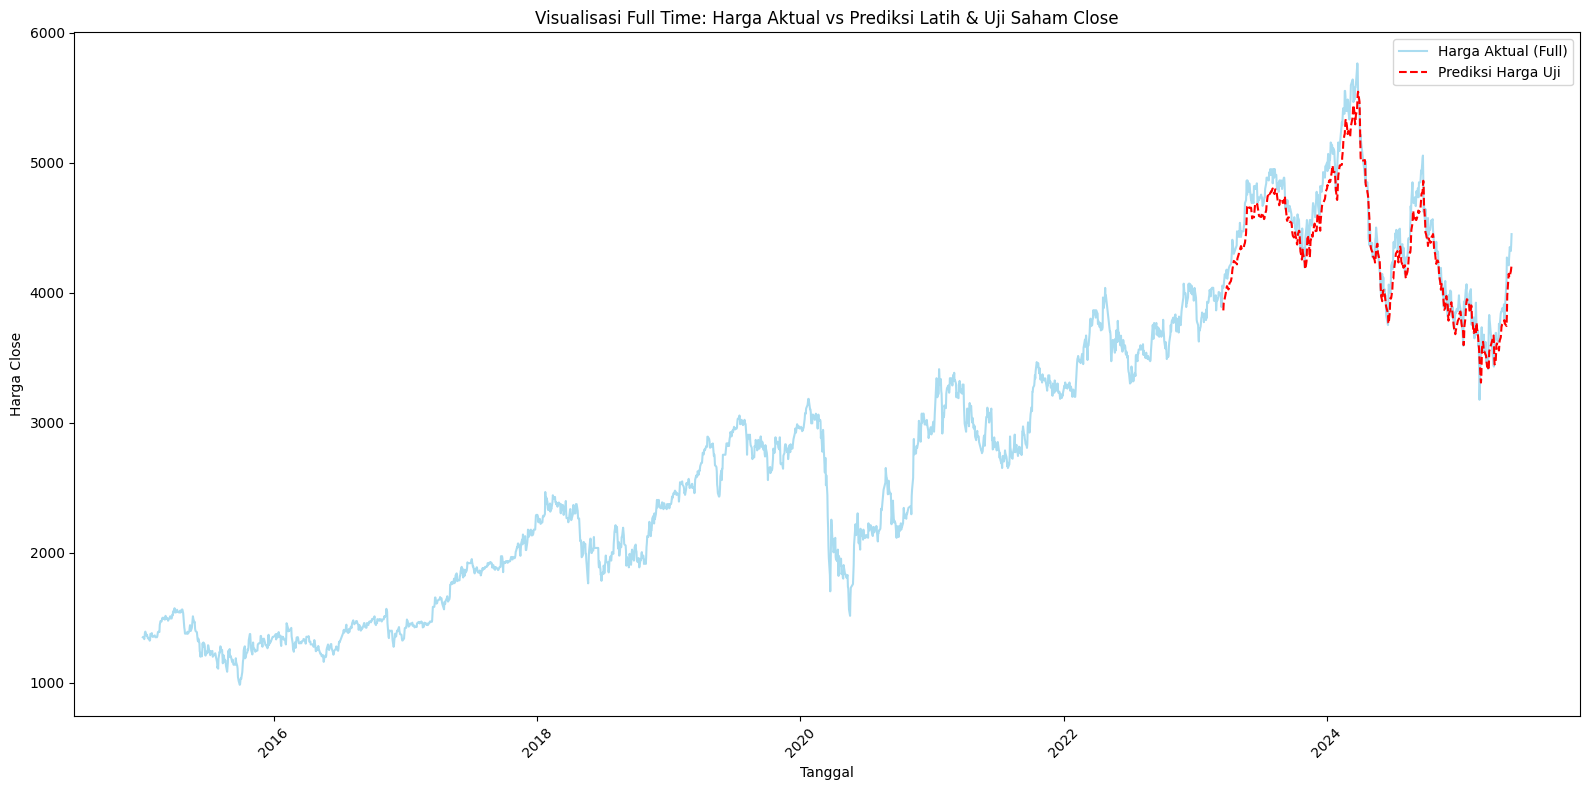

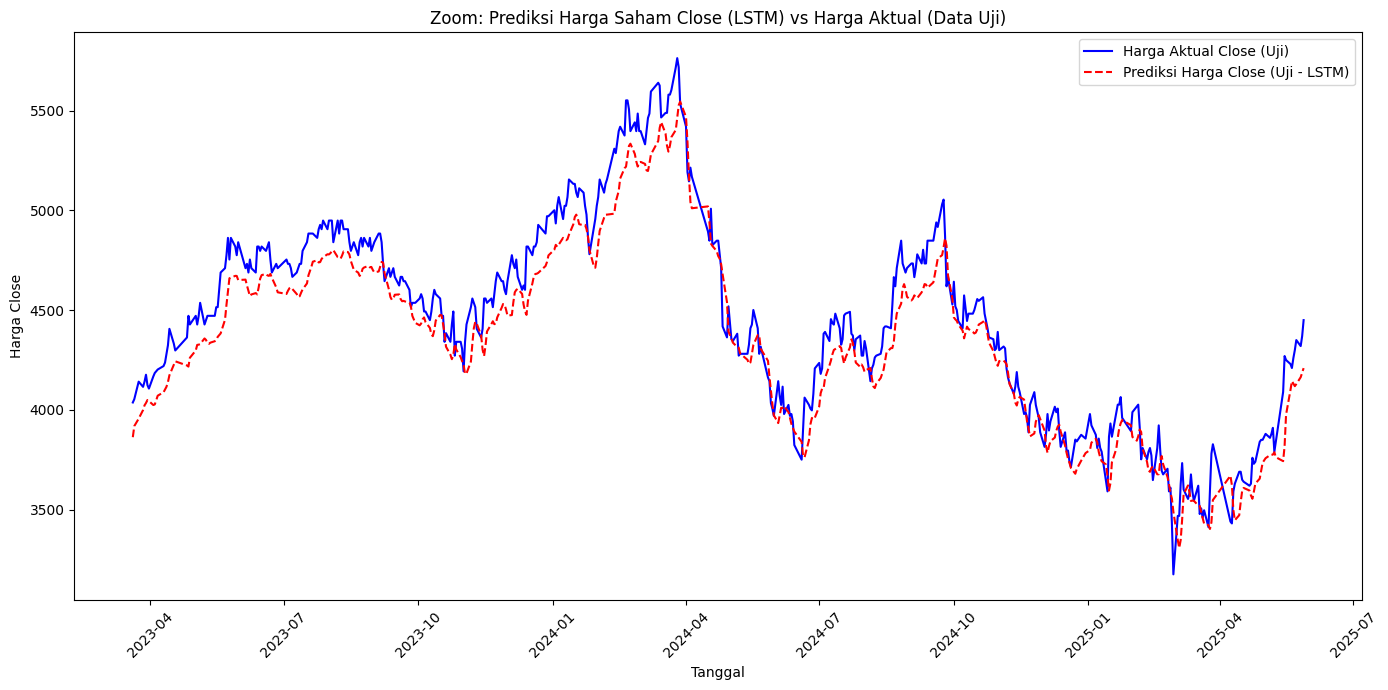


--- Memulai Pipeline Pelatihan Model Final ---

1. Persiapan Data (Menggunakan 100% Data)...
Bentuk data latih (100%): X_train: (2506, 60, 1), y_train: (2506,)
Persiapan data selesai.

2. Pembangunan Model LSTM...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,551 (1.09 MB)

 Trainable params: 284,551 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model dengan 100% data...
Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.0304
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0027
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0028
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0024
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0021
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0018
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0016
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0013
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0015
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0013
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0011
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0011
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0011
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 

In [5]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= jalankan_pipeline_lstm(
    df_input=df,
    target_column='Close',
    time_steps=60,
    train_split_ratio=0.8,
    lstm_units_list=[100, 100,100,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=50,
    batch_size=32,
    nama=4,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model LSTM ---
Bentuk data latih X_train: (1993, 60, 1), y_train (scaled): (1993,)
Persiapan data selesai.

2. Pembangunan Model LSTM...
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,551 (1.09 MB)

 Trainable params: 284,551 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0195 - val_loss: 0.0037
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 9.9850e-04 - val_loss: 0.0017
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 8.7504e-04 - val_loss: 0.0014
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 9.0466e-04 - val_loss: 0.0013
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 8.2369e-04 - val_loss: 0.0020
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 8.8838e-04 - val_loss: 0.0019
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - los

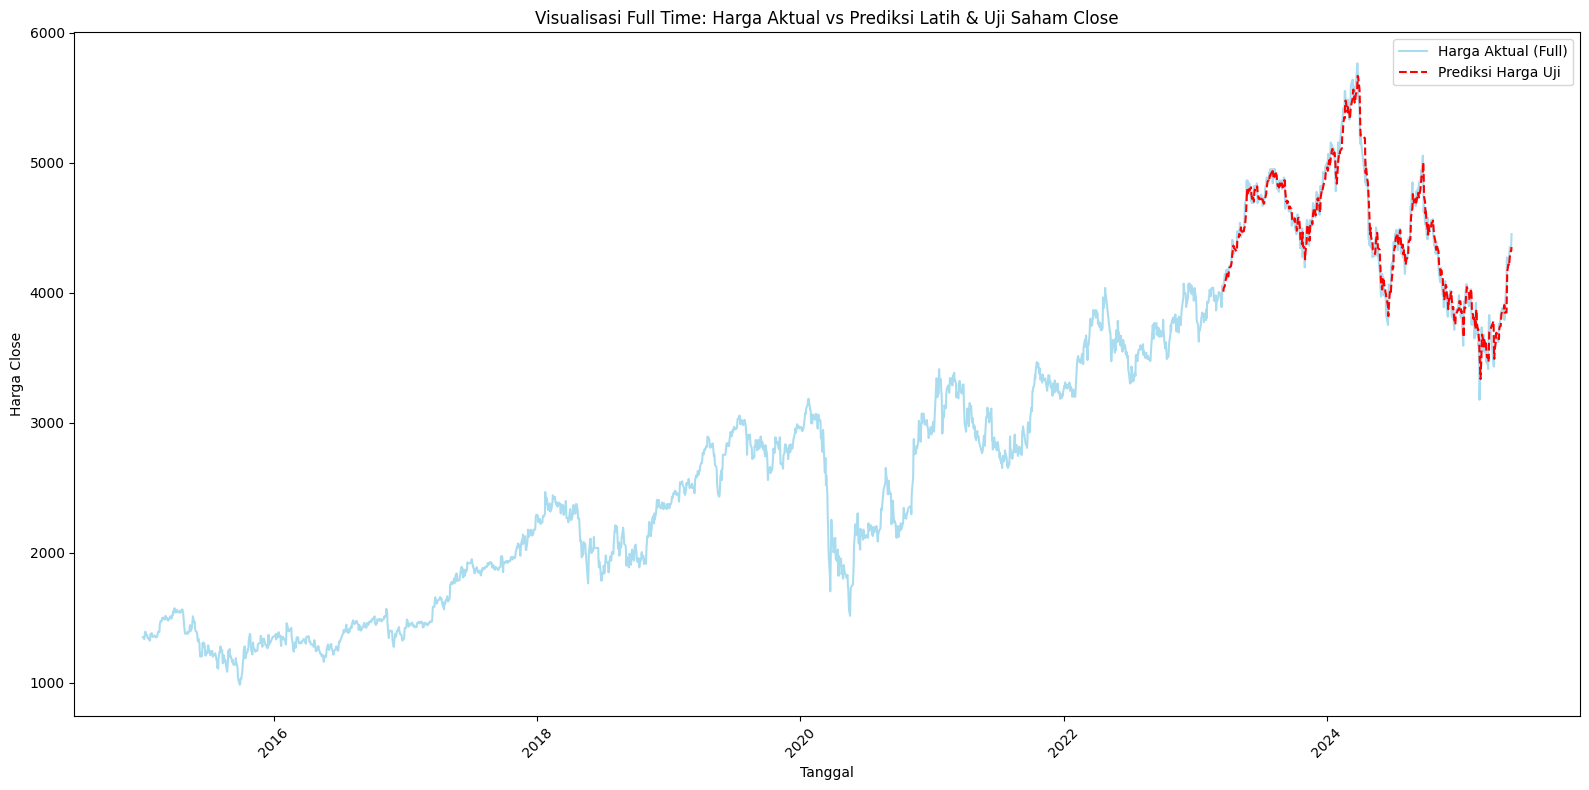

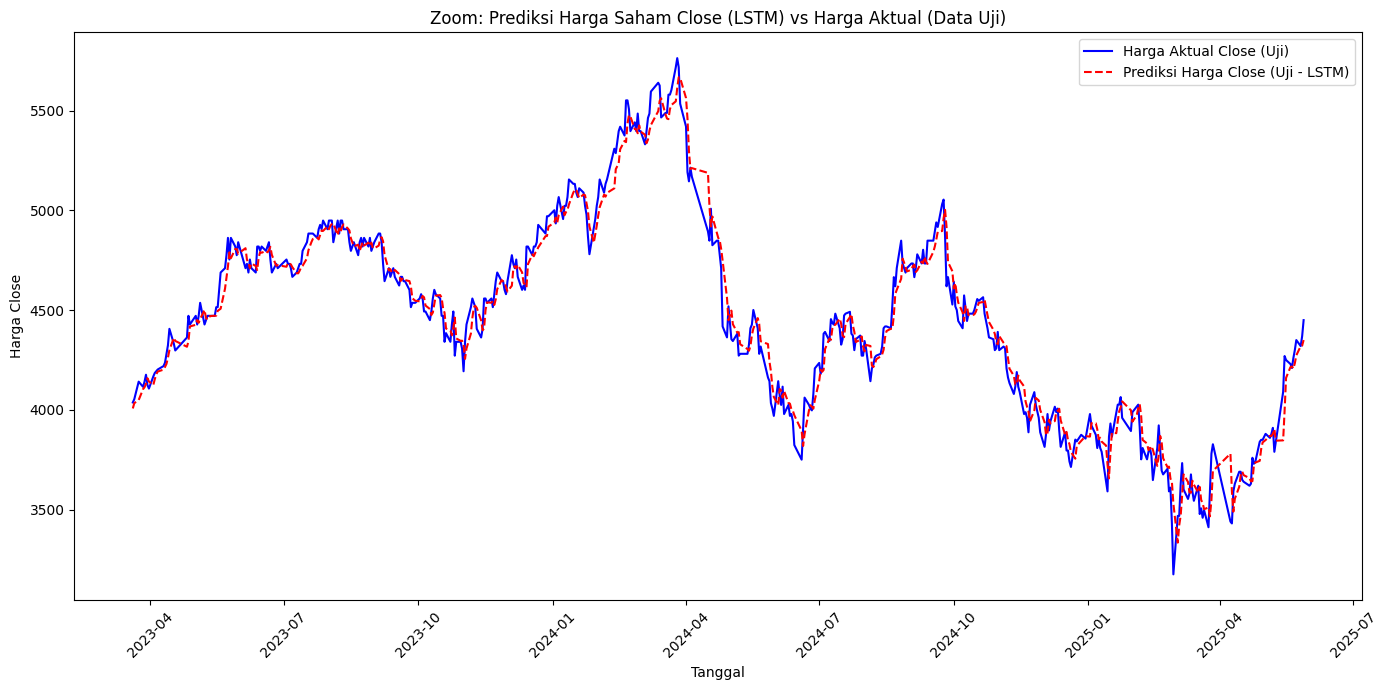

--- Memulai Pipeline Pelatihan Model Final ---

1. Persiapan Data (Menggunakan 100% Data)...
Bentuk data latih (100%): X_train: (2506, 60, 1), y_train: (2506,)
Persiapan data selesai.

2. Pembangunan Model LSTM...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,551 (1.09 MB)

 Trainable params: 284,551 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model dengan 100% data...
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0304
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0027
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0028
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0024
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0021
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0018
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0016
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0013
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0015
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0013
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0011
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0011
Epoch 13/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0011
Epoch 14/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms

In [6]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= jalankan_pipeline_lstm(
    df_input=df,
    target_column='Close',
    time_steps=60,
    train_split_ratio=0.8,
    lstm_units_list=[100, 100,100,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=100,
    batch_size=32,
    nama=4,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model LSTM ---
Bentuk data latih X_train: (1993, 60, 1), y_train (scaled): (1993,)
Persiapan data selesai.

2. Pembangunan Model LSTM...
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,151 (2.31 MB)

 Trainable params: 606,151 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - loss: 0.0299 - val_loss: 0.0067
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0024 - val_loss: 0.0085
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0022 - val_loss: 0.0045
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0012 - val_los

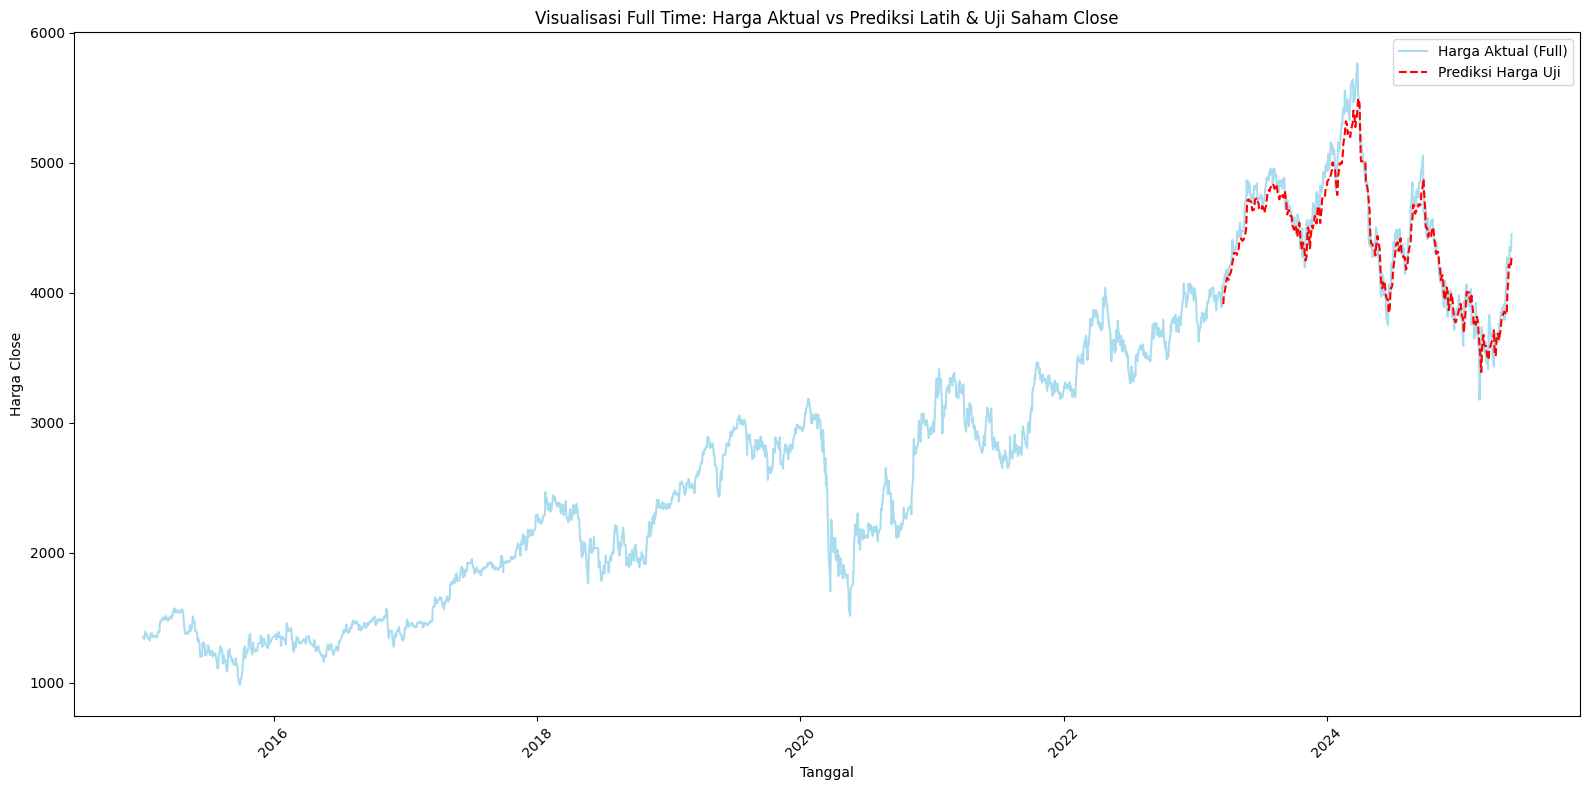

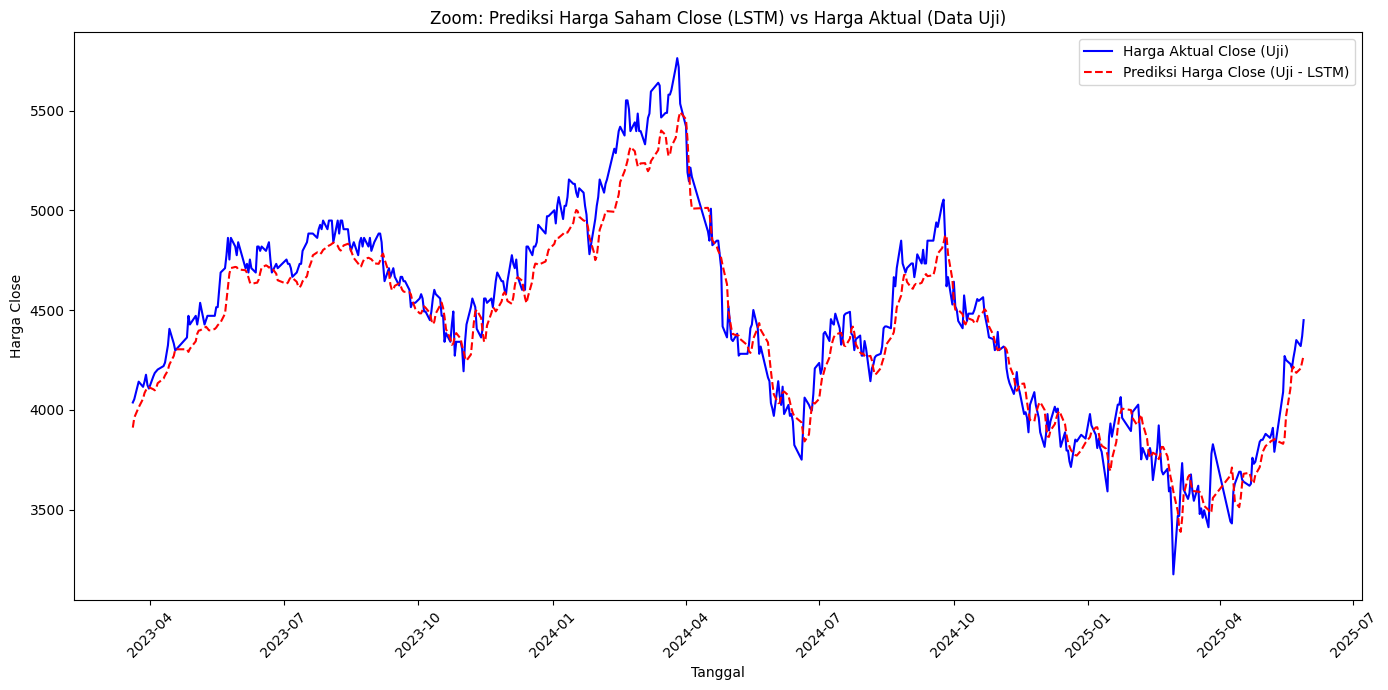

--- Memulai Pipeline Pelatihan Model Final ---

1. Persiapan Data (Menggunakan 100% Data)...
Bentuk data latih (100%): X_train: (2506, 60, 1), y_train: (2506,)
Persiapan data selesai.

2. Pembangunan Model LSTM...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,151 (2.31 MB)

 Trainable params: 606,151 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model dengan 100% data...
Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - loss: 0.0967
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0049
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0048
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0042
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 0.0035
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0037
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0026
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0026
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0025
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0025
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0025
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 0.0023
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0021
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━

In [7]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= jalankan_pipeline_lstm(
    df_input=df,
    target_column='Close',
    time_steps=60,
    train_split_ratio=0.8,
    lstm_units_list=[100, 100,100,100,100,100,100,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=50,
    batch_size=32,
    nama=8,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model LSTM ---
Bentuk data latih X_train: (1993, 60, 1), y_train (scaled): (1993,)
Persiapan data selesai.

2. Pembangunan Model LSTM...
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,151 (2.31 MB)

 Trainable params: 606,151 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 0.0299 - val_loss: 0.0067
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - loss: 0.0024 - val_loss: 0.0085
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - loss: 0.0022 - val_loss: 0.0045
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.001

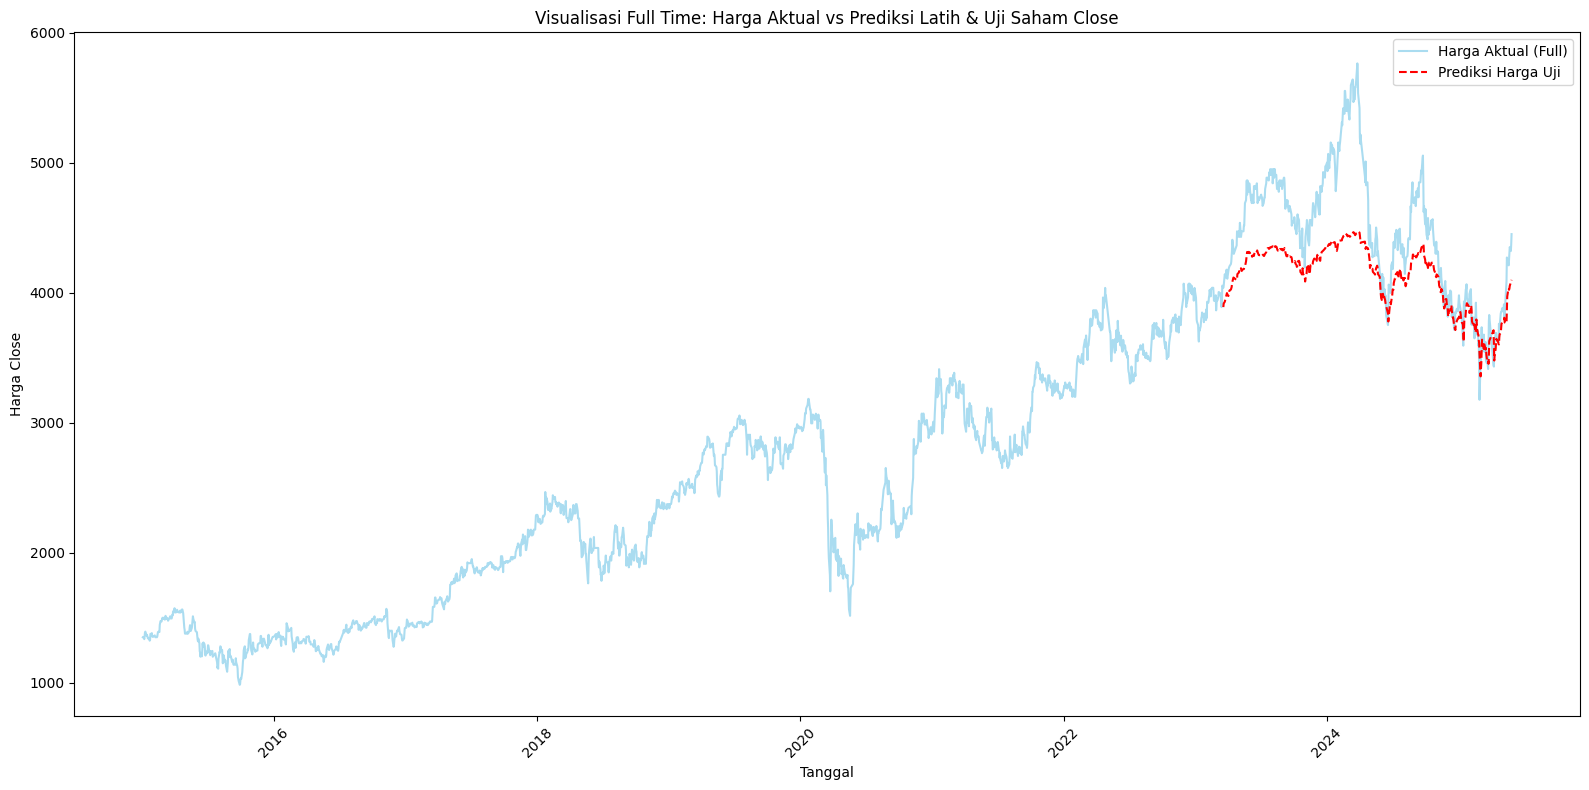

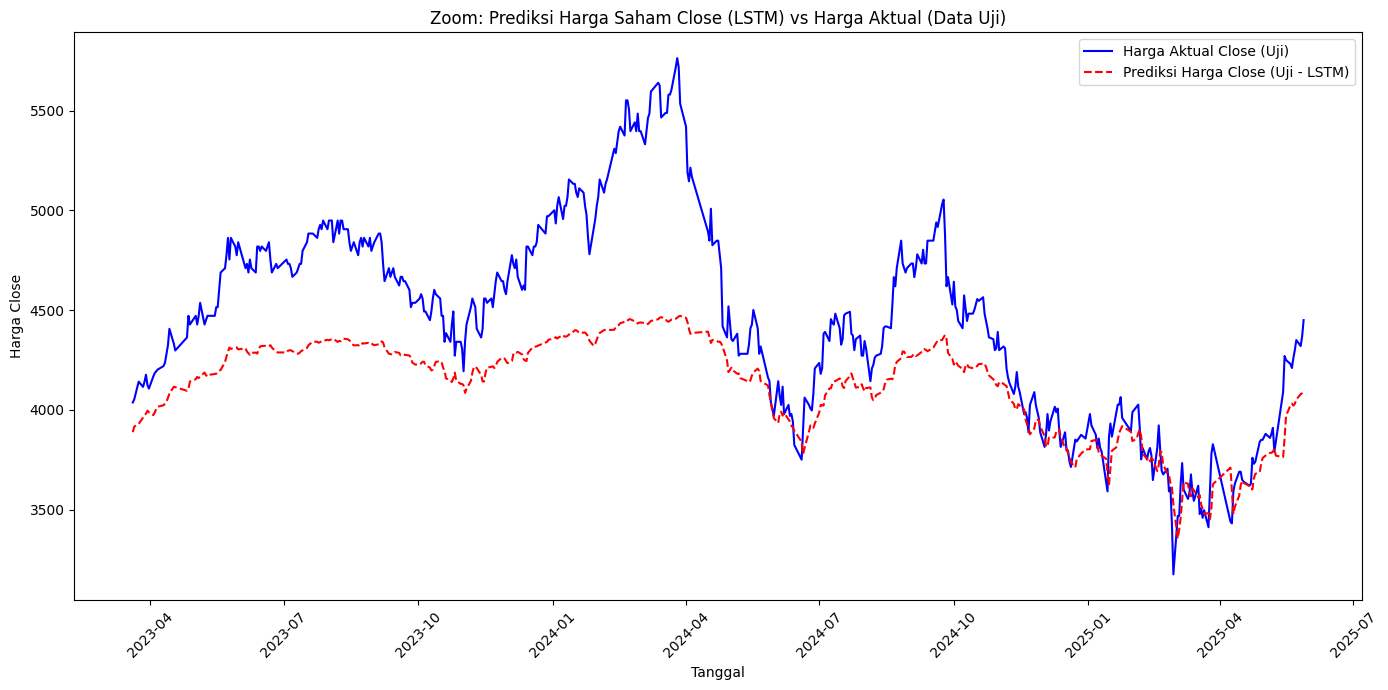

--- Memulai Pipeline Pelatihan Model Final ---

1. Persiapan Data (Menggunakan 100% Data)...
Bentuk data latih (100%): X_train: (2506, 60, 1), y_train: (2506,)
Persiapan data selesai.

2. Pembangunan Model LSTM...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,151 (2.31 MB)

 Trainable params: 606,151 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model dengan 100% data...
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - loss: 0.0967
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - loss: 0.0049
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - loss: 0.0048
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - loss: 0.0042
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - loss: 0.0035
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - loss: 0.0037
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - loss: 0.0026
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - loss: 0.0026
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.0025
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - loss: 0.0025
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.0025
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0023
Epoch 13/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0021
Epoch 14/100
79/79 ━━━━━━

In [13]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= jalankan_pipeline_lstm(
    df_input=df,
    target_column='Close',
    time_steps=60,
    train_split_ratio=0.8,
    lstm_units_list=[100, 100,100,100,100,100,100,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=100,
    batch_size=32,
    nama=8,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model LSTM ---
Bentuk data latih X_train: (2023, 30, 1), y_train (scaled): (2023,)
Persiapan data selesai.

2. Pembangunan Model LSTM...
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,551 (1.09 MB)

 Trainable params: 284,551 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0224 - val_loss: 0.0035
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 8.1523e-04 - val_loss: 0.0021
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 8.3497e-04 - val_loss: 0

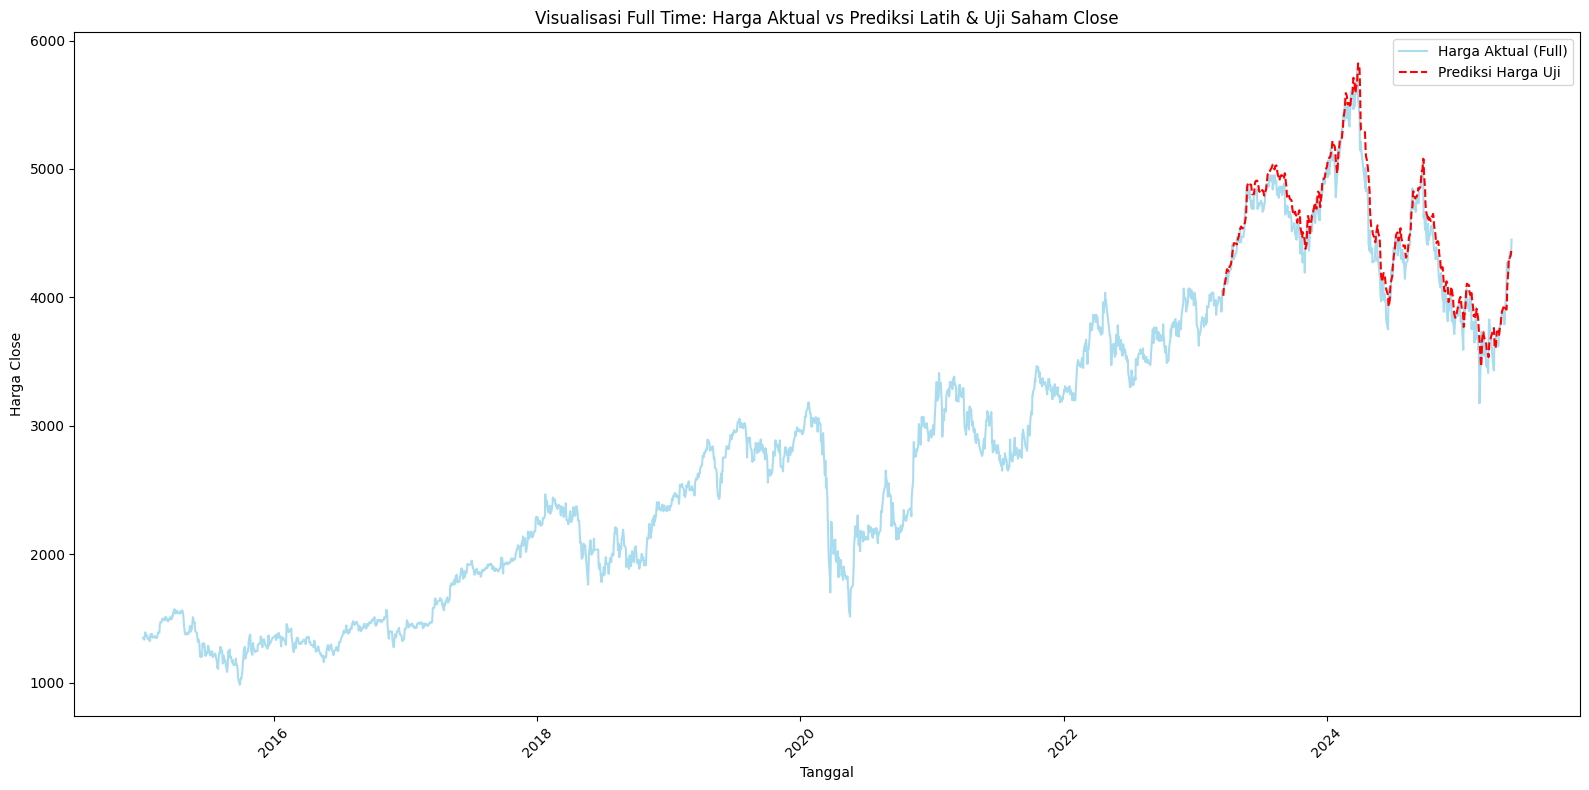

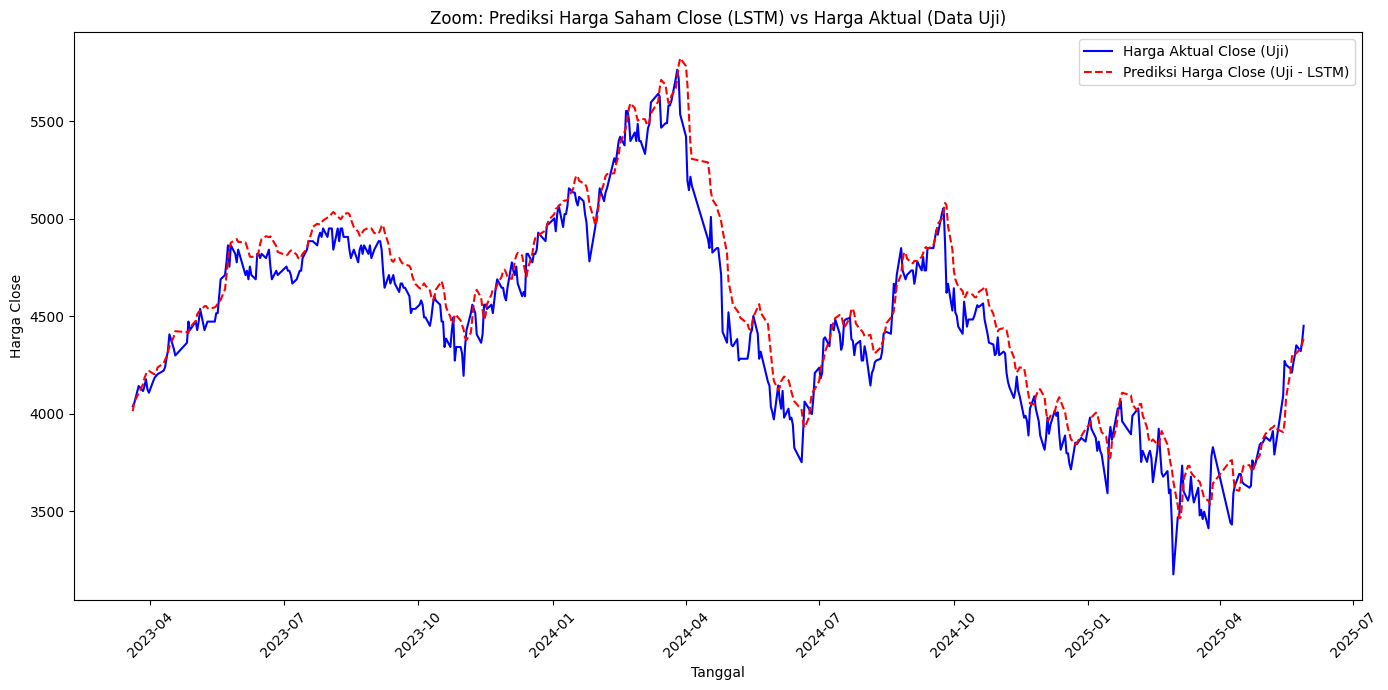

--- Memulai Pipeline Pelatihan Model Final ---

1. Persiapan Data (Menggunakan 100% Data)...
Bentuk data latih (100%): X_train: (2536, 30, 1), y_train: (2536,)
Persiapan data selesai.

2. Pembangunan Model LSTM...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,551 (1.09 MB)

 Trainable params: 284,551 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model dengan 100% data...
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0348
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0025
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0024
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0024
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0022
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0023
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0019
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0016
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0015
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0012
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0012
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0013
Epoch 13/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0013
Epoch 14/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 

In [9]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= jalankan_pipeline_lstm(
    df_input=df,
    target_column='Close',
    time_steps=30,
    train_split_ratio=0.8,
    lstm_units_list=[100, 100,100,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=50,
    batch_size=32,
    nama=3,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model LSTM ---
Bentuk data latih X_train: (2023, 30, 1), y_train (scaled): (2023,)
Persiapan data selesai.

2. Pembangunan Model LSTM...
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,551 (1.09 MB)

 Trainable params: 284,551 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0224 - val_loss: 0.0035
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 8.1523e-04 - val_loss: 0.0021
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 8.3497e-04 - 

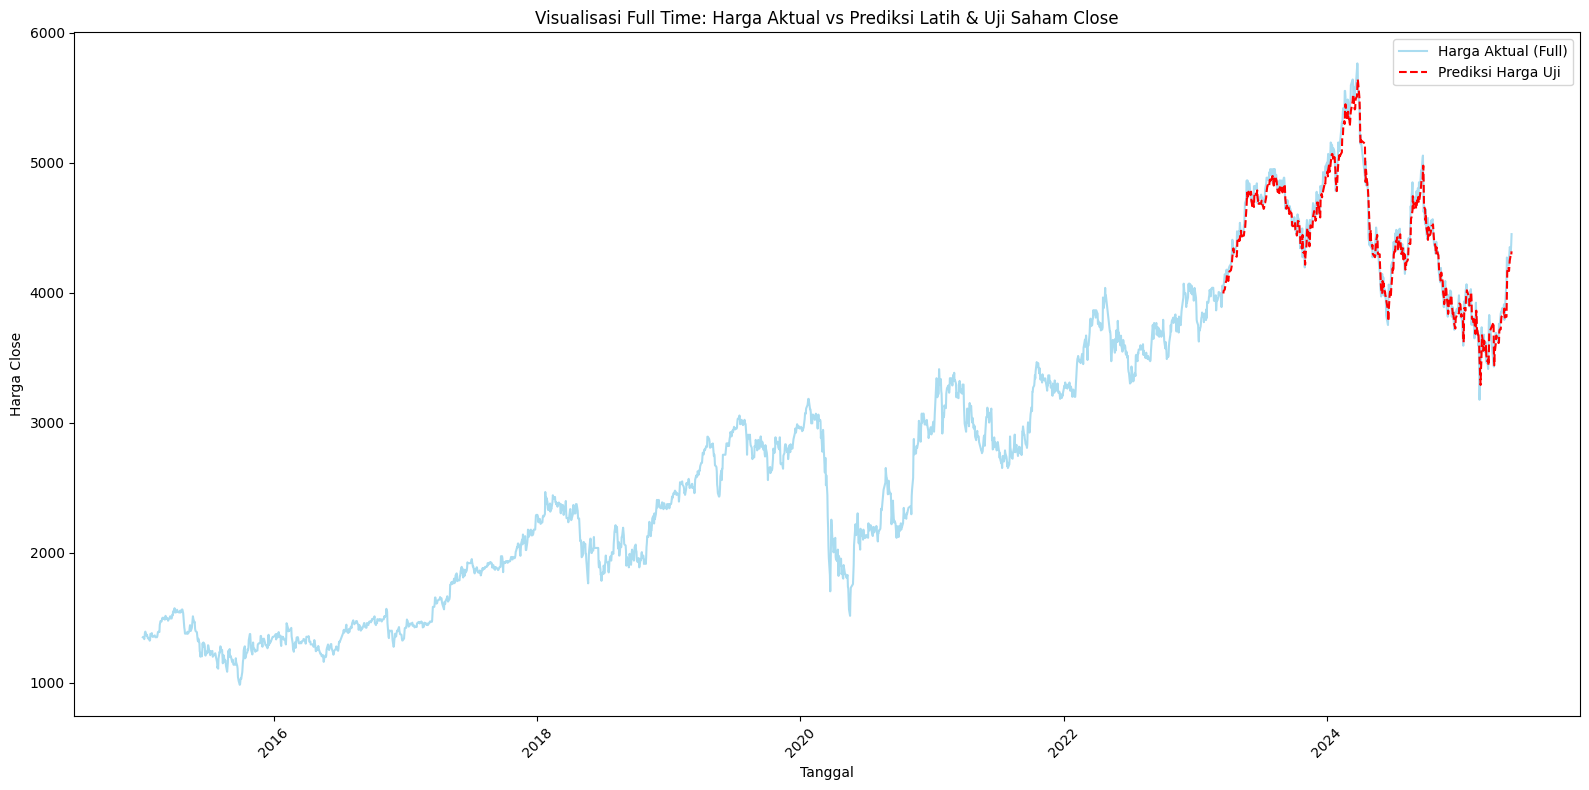

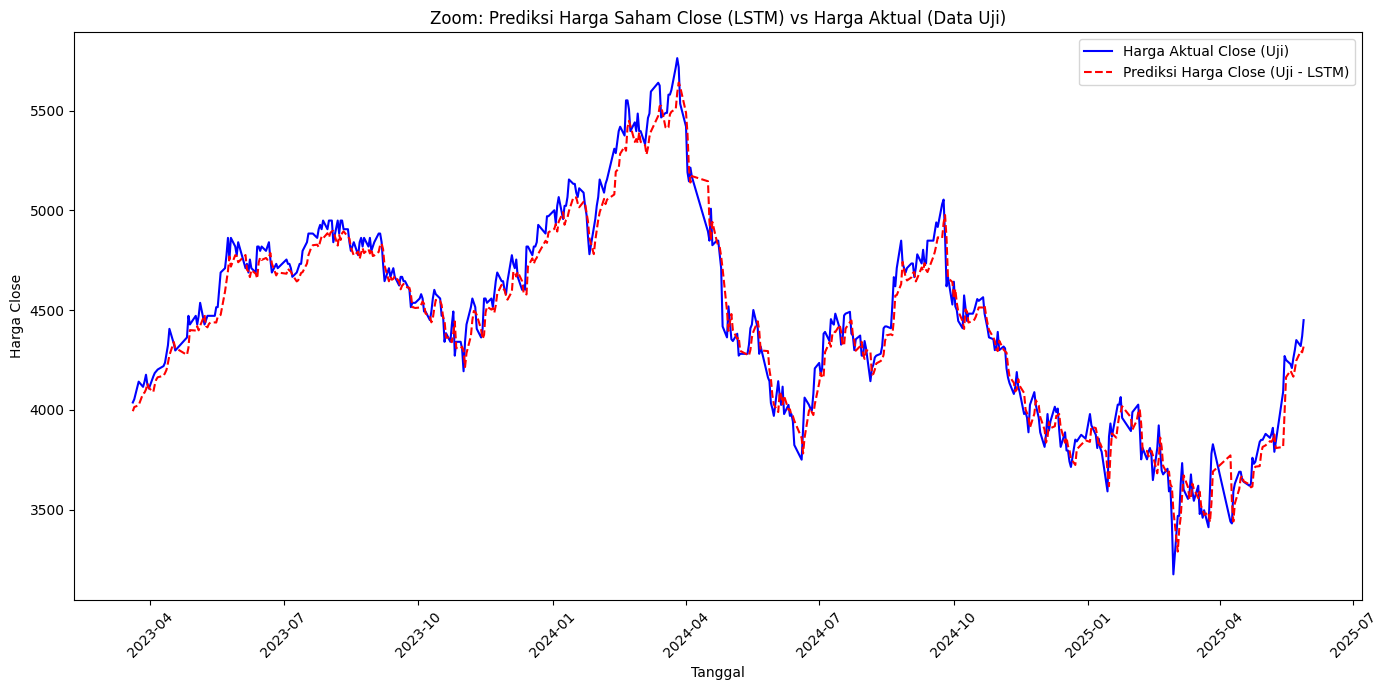

--- Memulai Pipeline Pelatihan Model Final ---

1. Persiapan Data (Menggunakan 100% Data)...
Bentuk data latih (100%): X_train: (2536, 30, 1), y_train: (2536,)
Persiapan data selesai.

2. Pembangunan Model LSTM...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,551 (1.09 MB)

 Trainable params: 284,551 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model dengan 100% data...
Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0348
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0025
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0024
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0024
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0022
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0023
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0019
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0016
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0015
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0012
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0012
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0013
Epoch 13/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0013
Epoch 14/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms

In [14]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= jalankan_pipeline_lstm(
    df_input=df,
    target_column='Close',
    time_steps=30,
    train_split_ratio=0.8,
    lstm_units_list=[100, 100,100,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=100,
    batch_size=32,
    nama=3,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model LSTM ---
Bentuk data latih X_train: (2023, 30, 1), y_train (scaled): (2023,)
Persiapan data selesai.

2. Pembangunan Model LSTM...
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,151 (2.31 MB)

 Trainable params: 606,151 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.0236 - val_loss: 0.0050
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0026 - val_loss: 0.0058
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0024 - val_loss: 0.0047
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0020 - val_loss: 0.0074
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0022 - val_loss: 0.0080
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0023 - val_loss: 0.0106
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0017 - val_loss: 0.0070
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0015 - val_loss: 0.0075
E

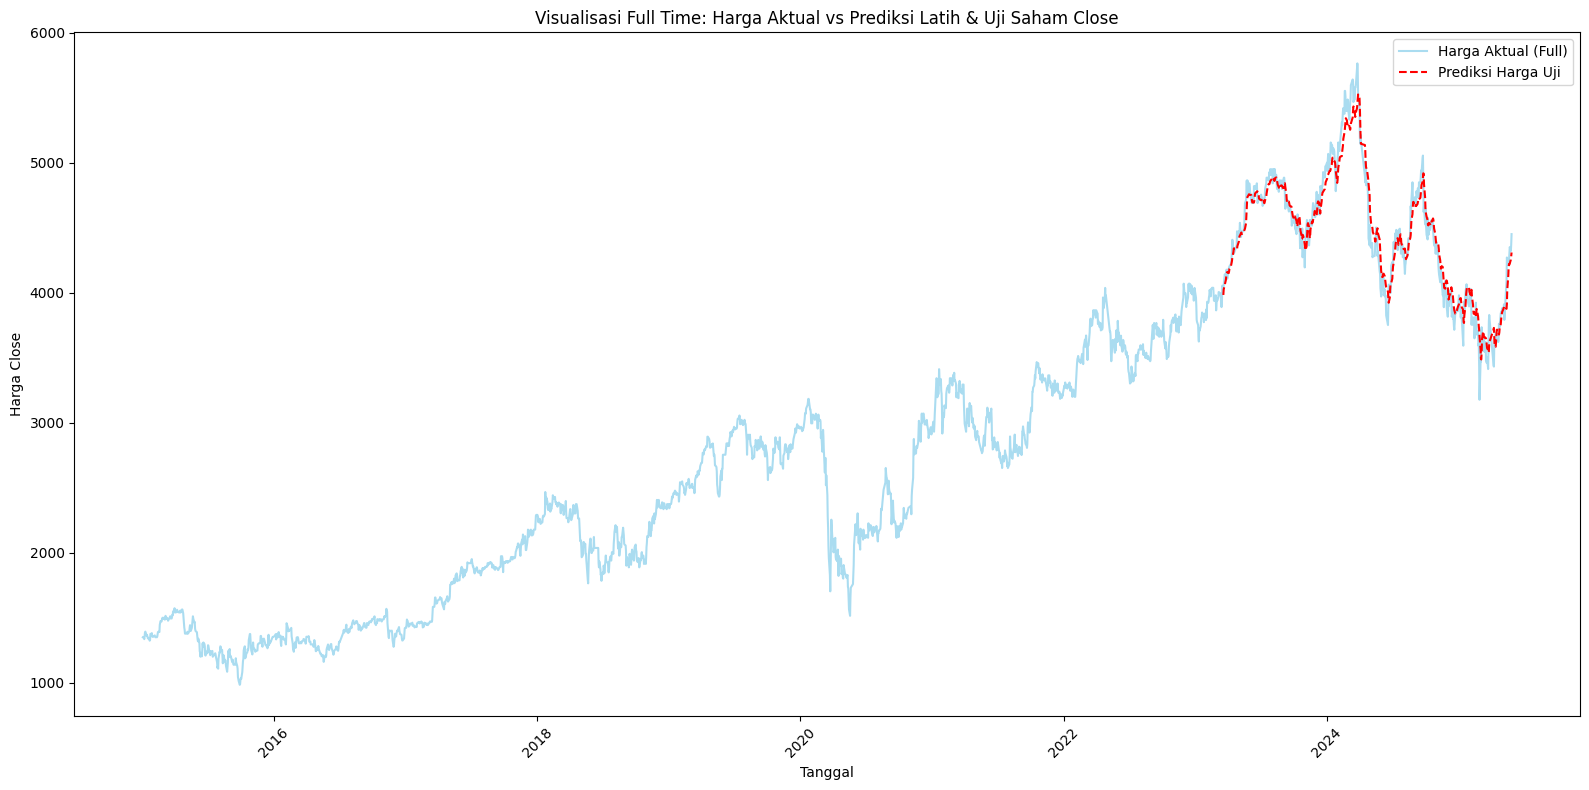

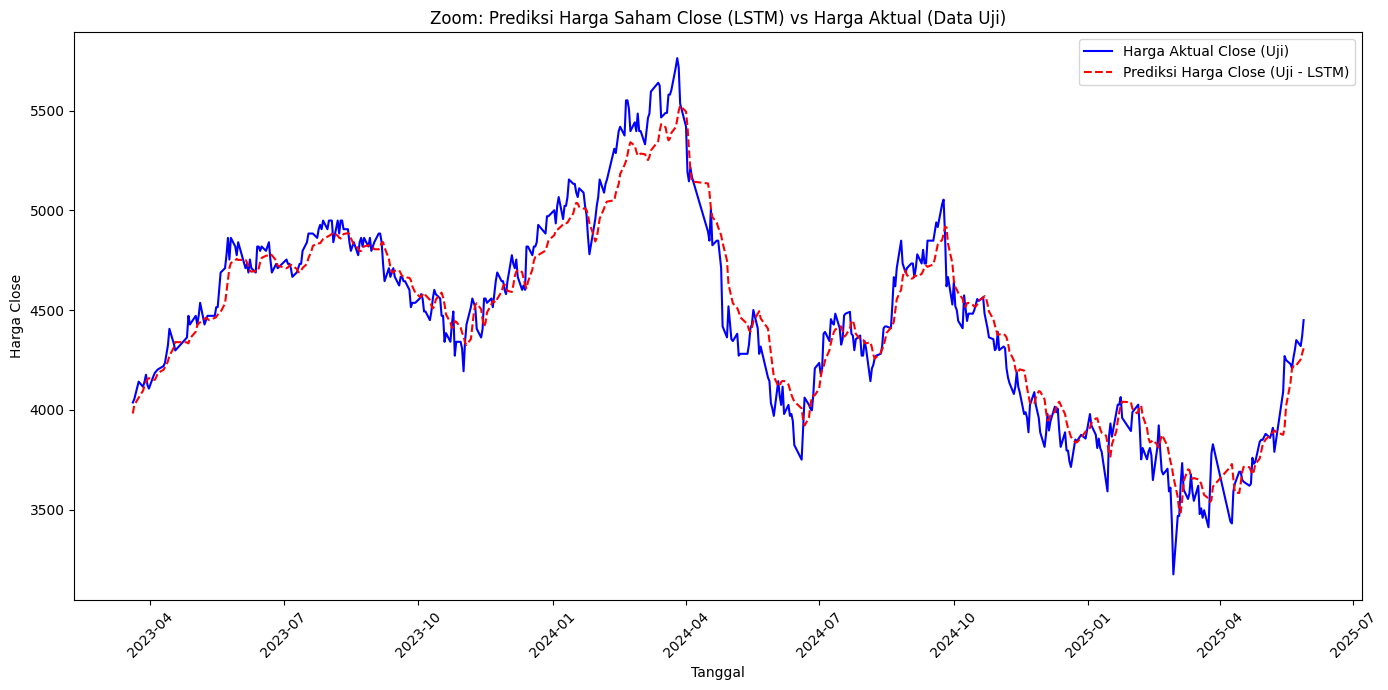

--- Memulai Pipeline Pelatihan Model Final ---

1. Persiapan Data (Menggunakan 100% Data)...
Bentuk data latih (100%): X_train: (2536, 30, 1), y_train: (2536,)
Persiapan data selesai.

2. Pembangunan Model LSTM...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,151 (2.31 MB)

 Trainable params: 606,151 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model dengan 100% data...
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0408
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0043
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0041
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0039
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0042
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0031
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0032
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0028
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0029
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0023
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0023
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0019
Epoch 13/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0023
Epoch 14/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss:

In [11]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= jalankan_pipeline_lstm(
    df_input=df,
    target_column='Close',
    time_steps=30,
    train_split_ratio=0.8,
    lstm_units_list=[100, 100,100,100,100,100,100,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=50,
    batch_size=32,
    nama=5,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model LSTM ---
Bentuk data latih X_train: (2023, 30, 1), y_train (scaled): (2023,)
Persiapan data selesai.

2. Pembangunan Model LSTM...
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,151 (2.31 MB)

 Trainable params: 606,151 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0236 - val_loss: 0.0050
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0026 - val_loss: 0.0058
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0024 - val_loss: 0.0047
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0020 - val_loss: 0.0074
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0022 - val_loss: 0.0080
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0023 - val_loss: 0.0106
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0017 - val_loss: 0.0070
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0015 - val_los

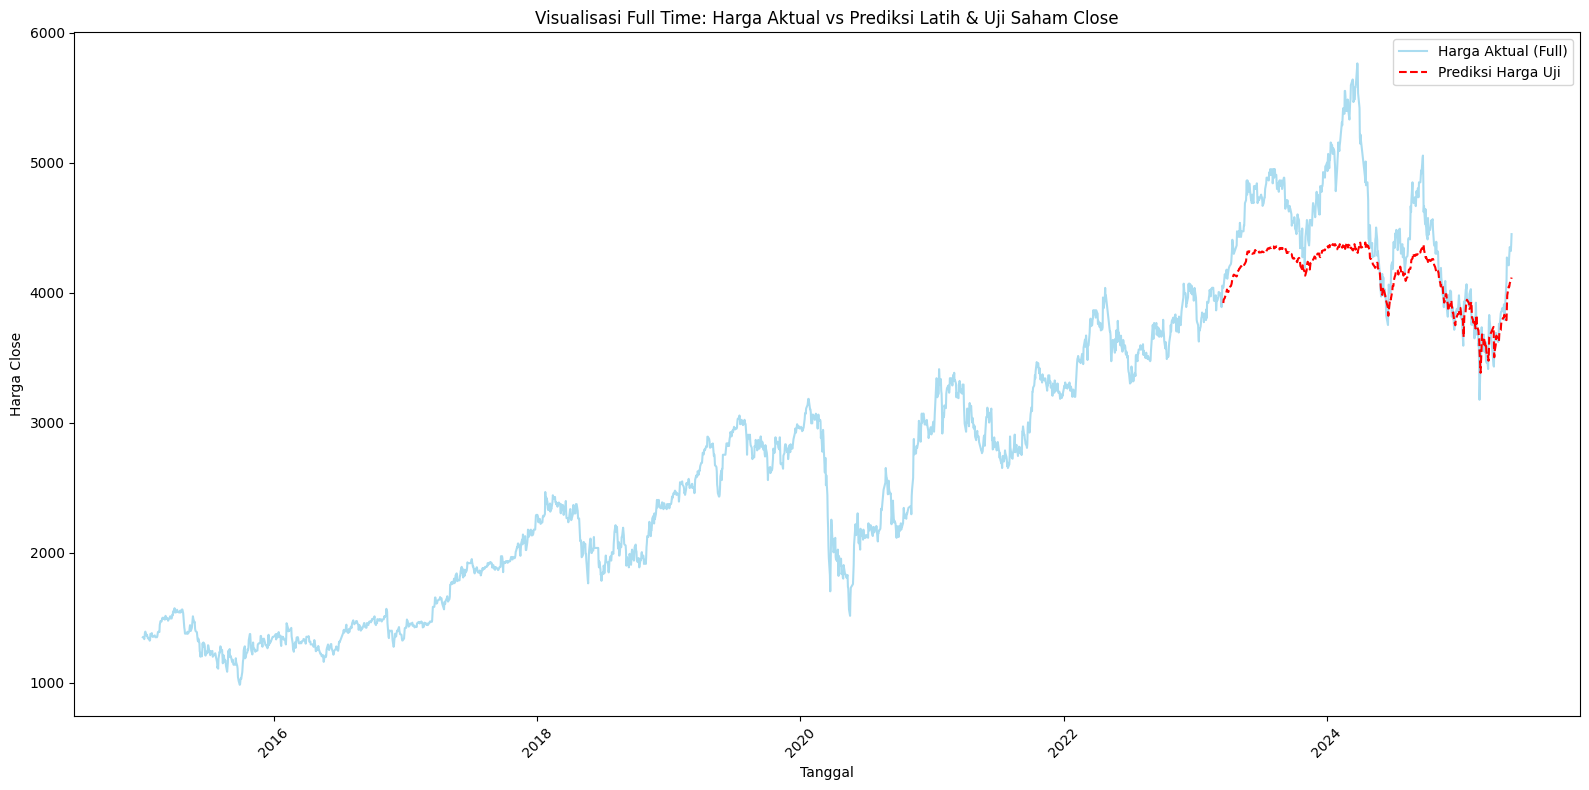

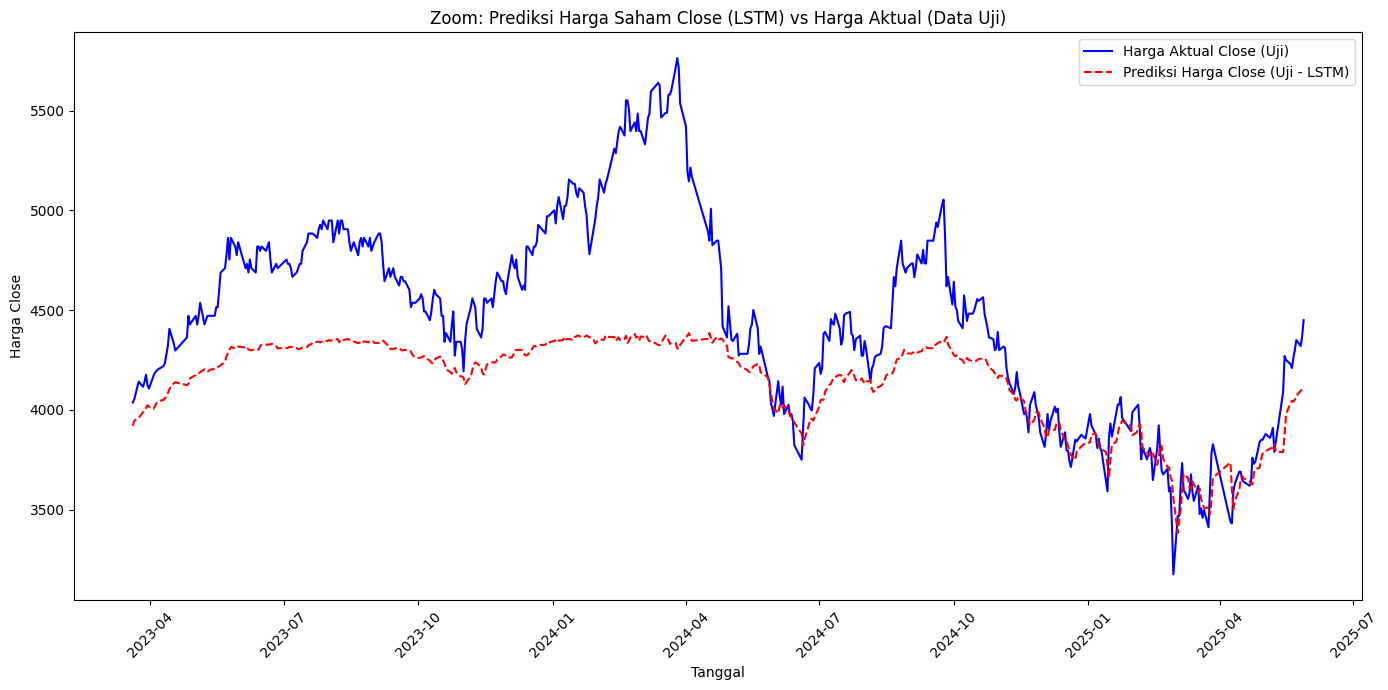

--- Memulai Pipeline Pelatihan Model Final ---

1. Persiapan Data (Menggunakan 100% Data)...
Bentuk data latih (100%): X_train: (2536, 30, 1), y_train: (2536,)
Persiapan data selesai.

2. Pembangunan Model LSTM...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,151 (2.31 MB)

 Trainable params: 606,151 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model dengan 100% data...
Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0408
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0043
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0041
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0039
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0042
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0031
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0032
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0028
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0029
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0023
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0023
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0019
Epoch 13/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0023
Epoch 14/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69m

In [12]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= jalankan_pipeline_lstm(
    df_input=df,
    target_column='Close',
    time_steps=30,
    train_split_ratio=0.8,
    lstm_units_list=[100, 100,100,100,100,100,100,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=100,
    batch_size=32,
    nama=7,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model LSTM ---
Bentuk data latih X_train: (1993, 60, 1), y_train (scaled): (1993,)
Persiapan data selesai.

2. Pembangunan Model LSTM...
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,351 (1.70 MB)

 Trainable params: 445,351 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.0330 - val_loss: 0.0043
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0015 - val_loss: 0.0082
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0011 - val_loss: 0.0

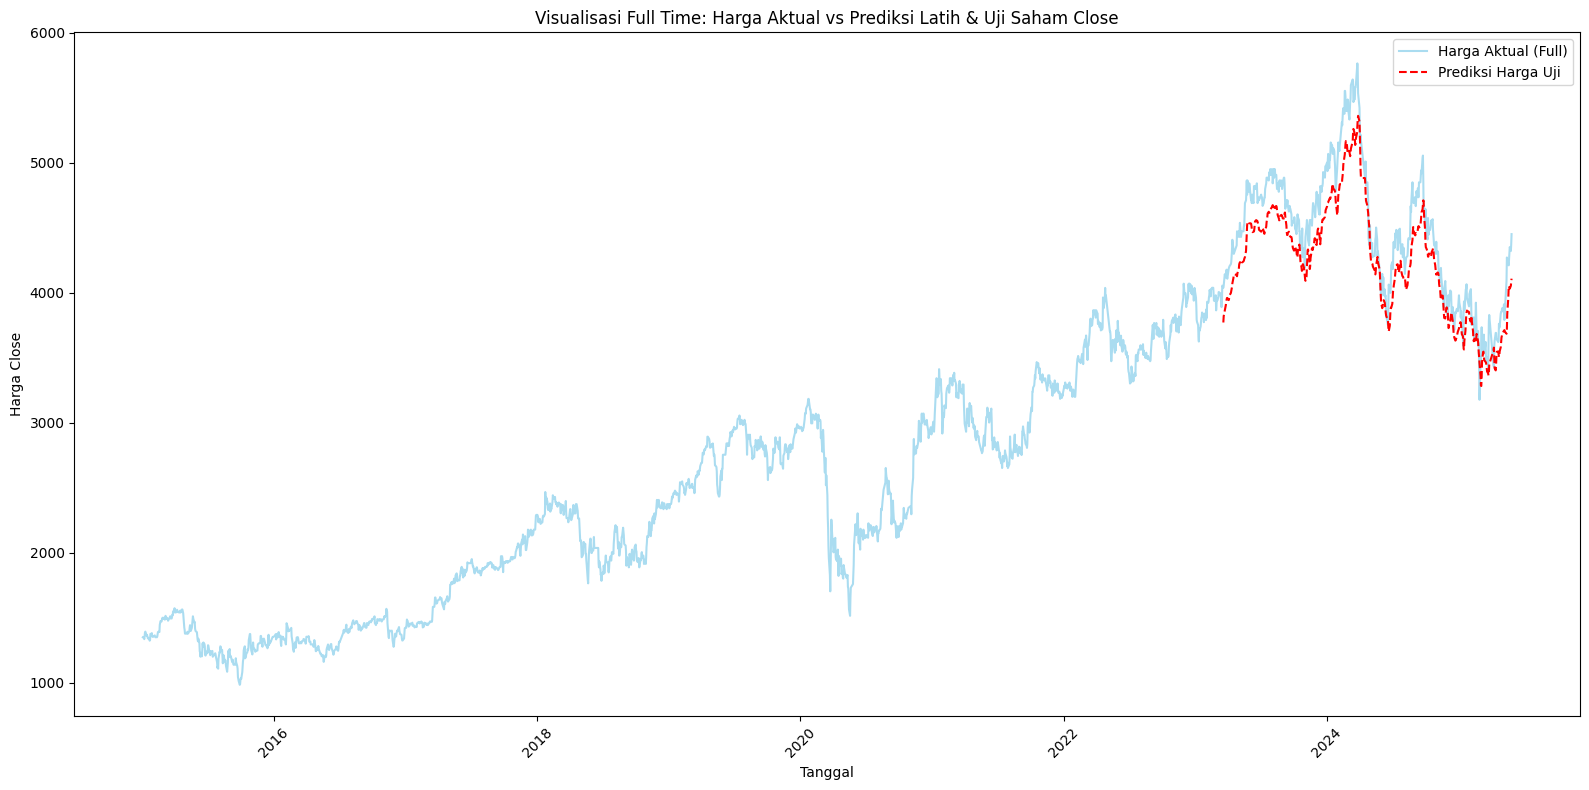

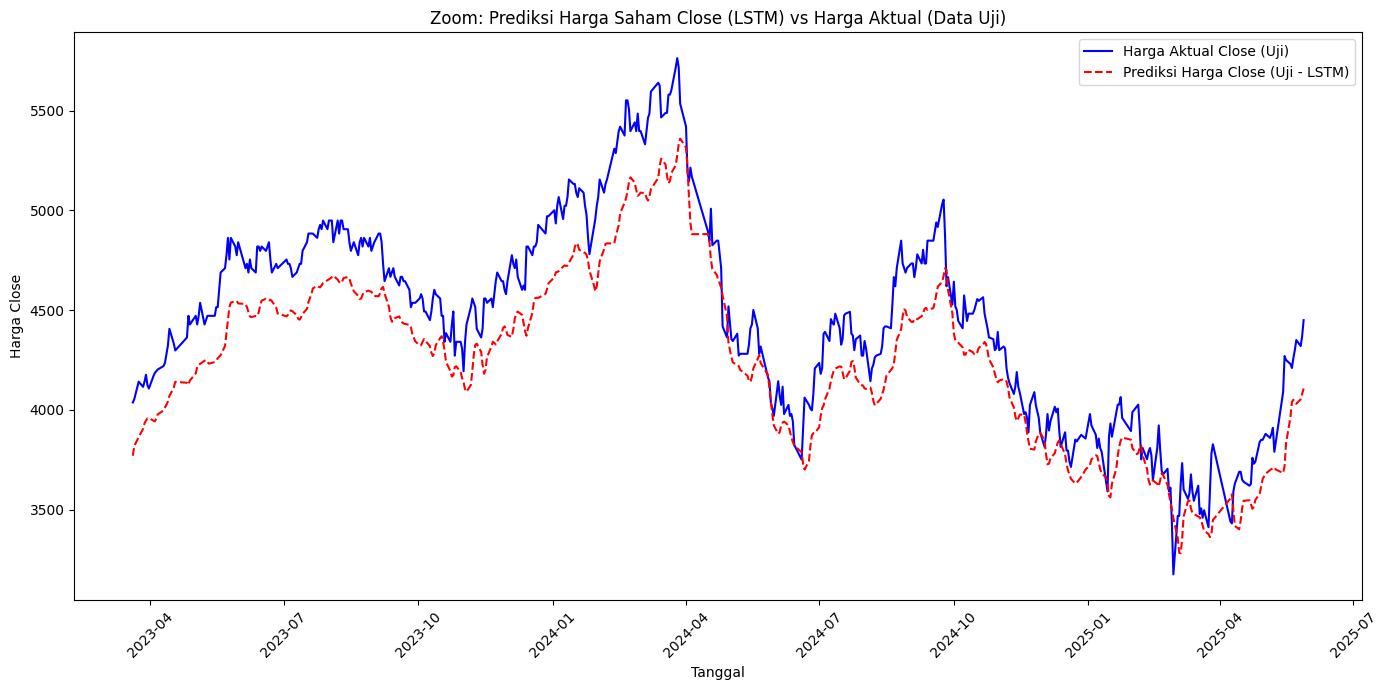

--- Memulai Pipeline Pelatihan Model Final ---

1. Persiapan Data (Menggunakan 100% Data)...
Bentuk data latih (100%): X_train: (2506, 60, 1), y_train: (2506,)
Persiapan data selesai.

2. Pembangunan Model LSTM...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,351 (1.70 MB)

 Trainable params: 445,351 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model dengan 100% data...
Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - loss: 0.0614
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.0039
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0030
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0029
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0026
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0025
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.0021
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0025
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0018
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.0018
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0017
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0016
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.0015
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss:

In [15]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= jalankan_pipeline_lstm(
    df_input=df,
    target_column='Close',
    time_steps=60,
    train_split_ratio=0.8,
    lstm_units_list=[100, 100,100,100,100,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=50,
    batch_size=32,
    nama=6,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model LSTM ---
Bentuk data latih X_train: (1993, 60, 1), y_train (scaled): (1993,)
Persiapan data selesai.

2. Pembangunan Model LSTM...
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,351 (1.70 MB)

 Trainable params: 445,351 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.0330 - val_loss: 0.0043
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0015 - val_loss: 0.0082
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0011 - v

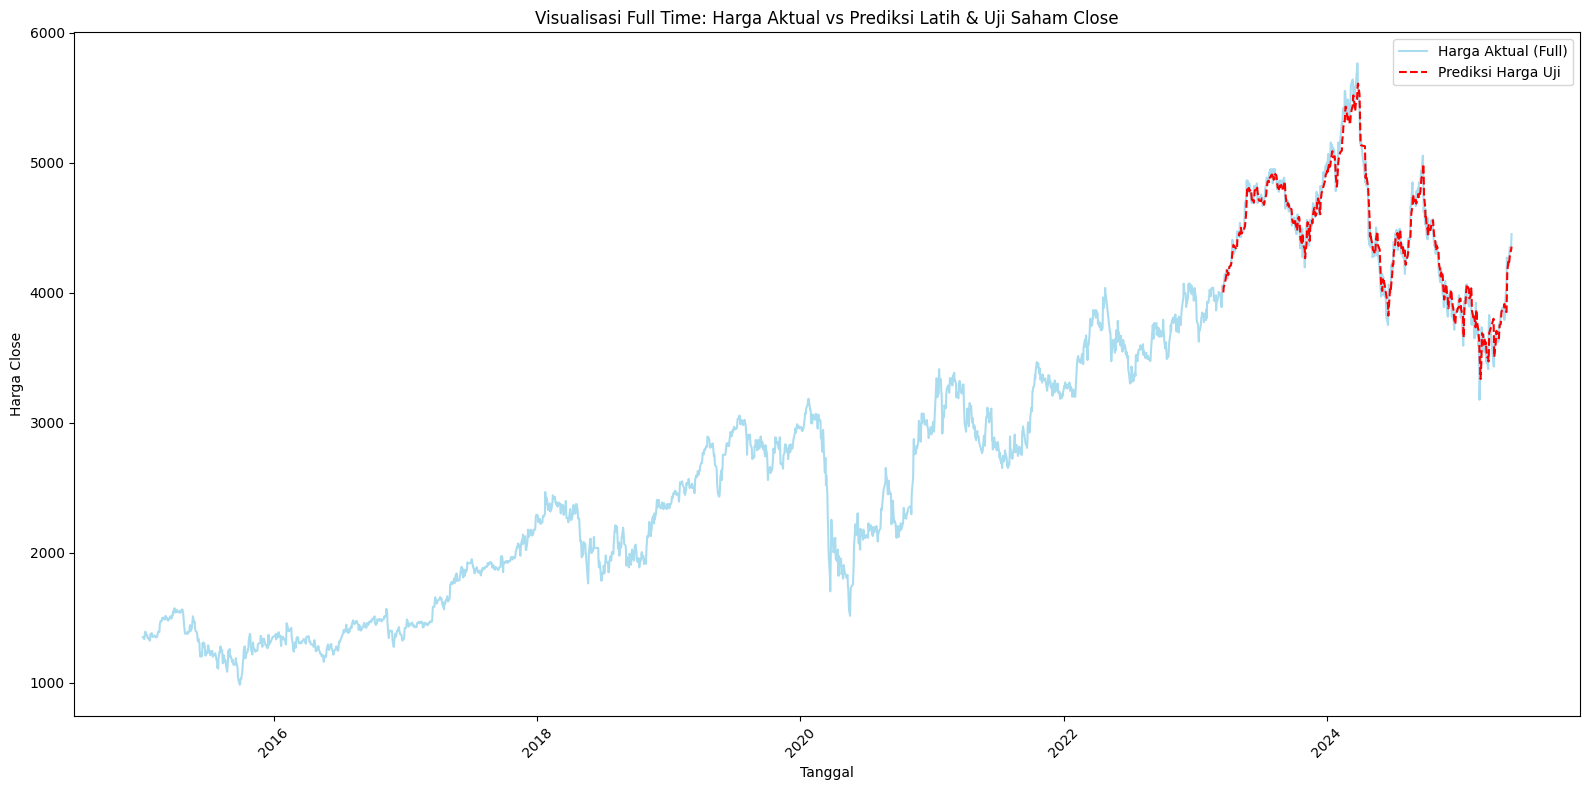

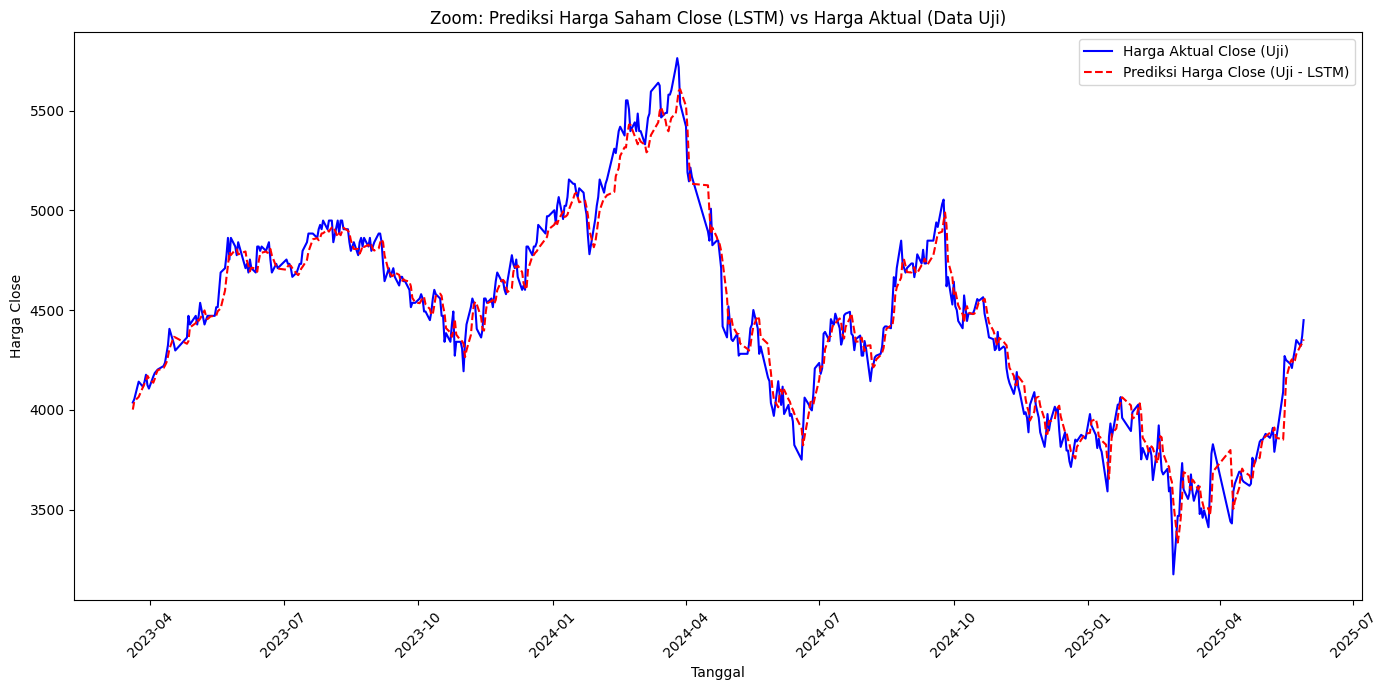

--- Memulai Pipeline Pelatihan Model Final ---

1. Persiapan Data (Menggunakan 100% Data)...
Bentuk data latih (100%): X_train: (2506, 60, 1), y_train: (2506,)
Persiapan data selesai.

2. Pembangunan Model LSTM...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,351 (1.70 MB)

 Trainable params: 445,351 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model dengan 100% data...
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - loss: 0.0614
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0039
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.0030
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0029
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0026
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0025
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0021
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0025
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0018
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - loss: 0.0018
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - loss: 0.0017
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0016
Epoch 13/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0015
Epoch 14/100
79/79 ━━━━━━━━━━━━━━━━━━━

In [16]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= jalankan_pipeline_lstm(
    df_input=df,
    target_column='Close',
    time_steps=60,
    train_split_ratio=0.8,
    lstm_units_list=[100, 100,100,100,100,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=100,
    batch_size=32,
    nama=6,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model LSTM ---
Bentuk data latih X_train: (2023, 30, 1), y_train (scaled): (2023,)
Persiapan data selesai.

2. Pembangunan Model LSTM...
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,351 (1.70 MB)

 Trainable params: 445,351 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.0322 - val_loss: 0.0100
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0017 - val_loss: 0.0073
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0018 - val_loss: 0.0077
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0015 - val_loss: 0.0137
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0012 - val_loss: 0.0088
E

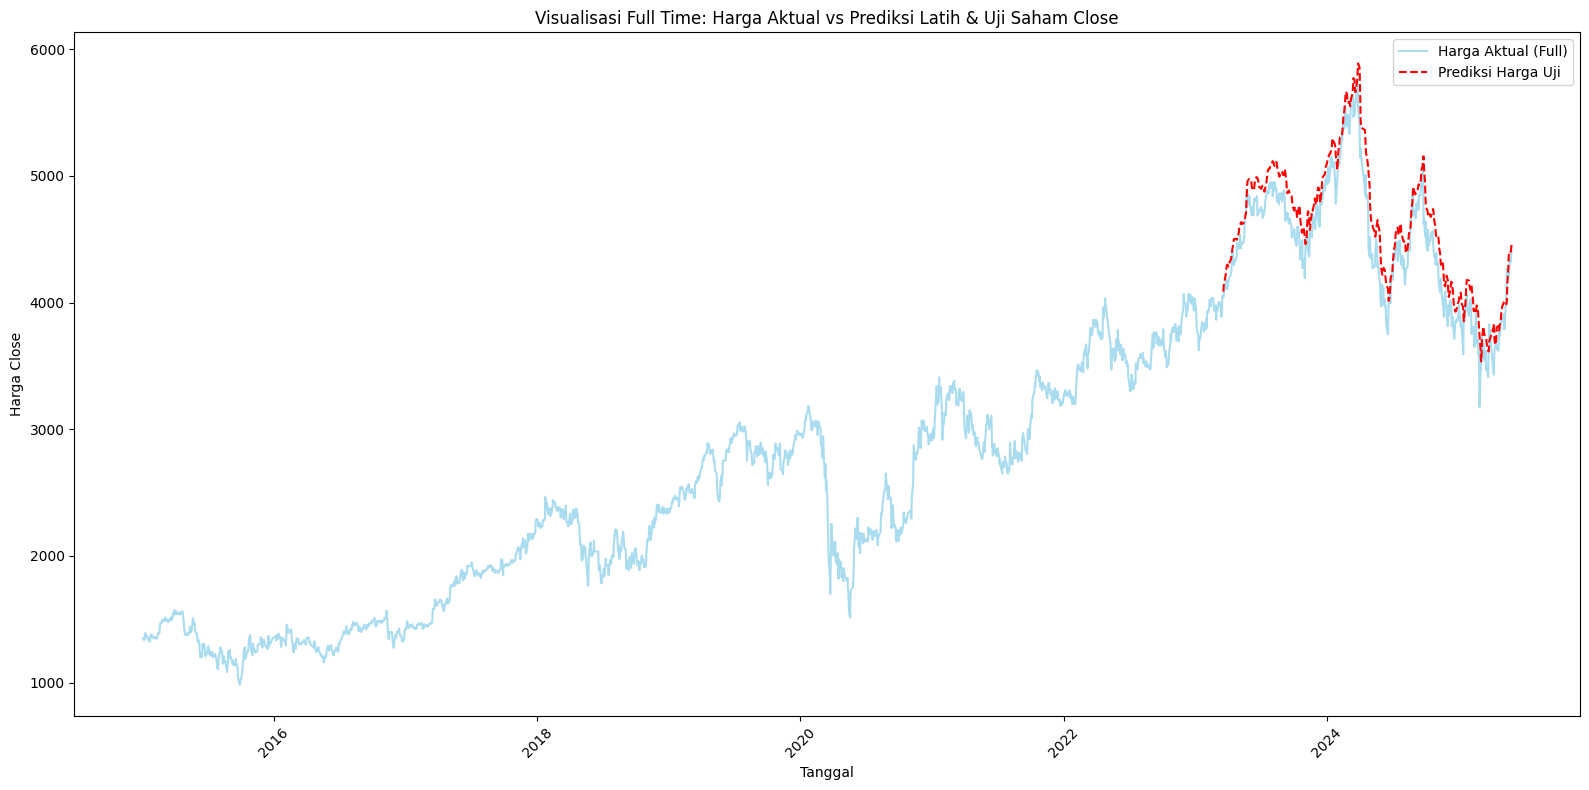

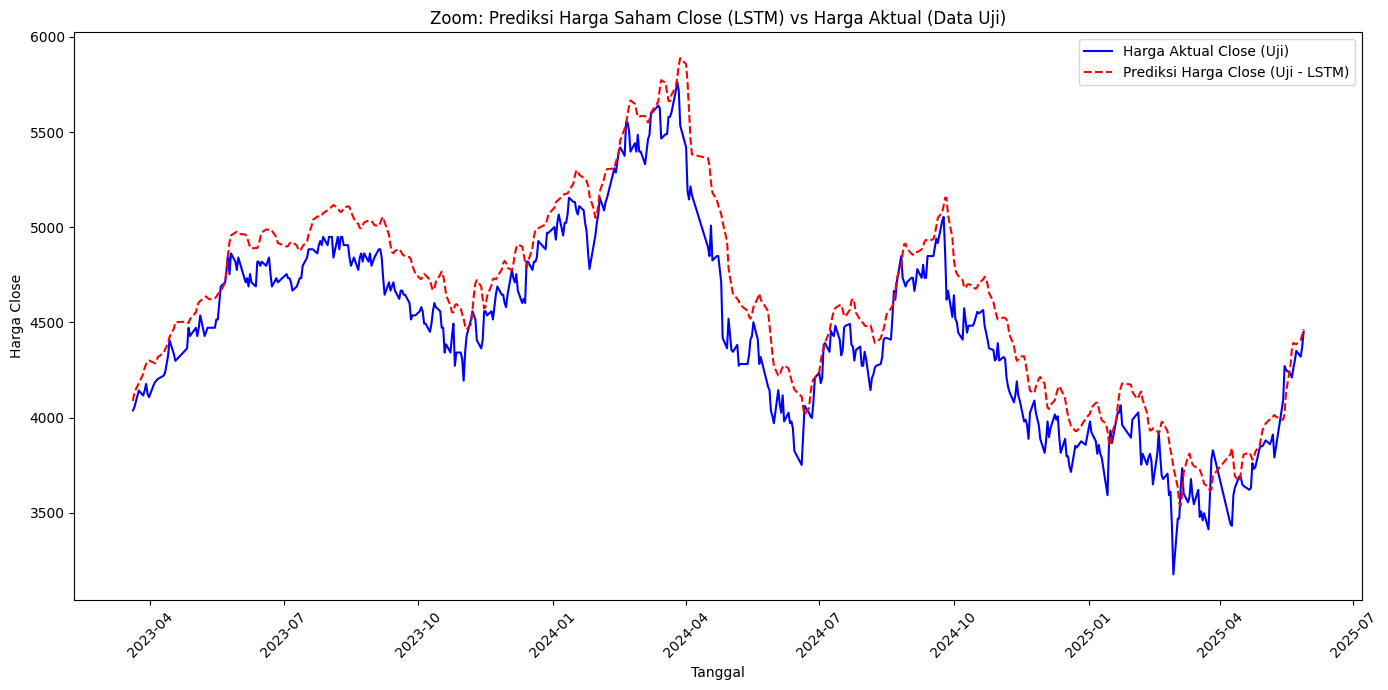

--- Memulai Pipeline Pelatihan Model Final ---

1. Persiapan Data (Menggunakan 100% Data)...
Bentuk data latih (100%): X_train: (2536, 30, 1), y_train: (2536,)
Persiapan data selesai.

2. Pembangunan Model LSTM...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,351 (1.70 MB)

 Trainable params: 445,351 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model dengan 100% data...
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0423
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0038
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0034
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0028
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0029
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0029
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0027
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0021
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0023
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0021
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0018
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0016
Epoch 13/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0016
Epoch 14/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss:

In [17]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= jalankan_pipeline_lstm(
    df_input=df,
    target_column='Close',
    time_steps=30,
    train_split_ratio=0.8,
    lstm_units_list=[100, 100,100,100,100,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=50,
    batch_size=32,
    nama=36,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model LSTM ---
Bentuk data latih X_train: (2023, 30, 1), y_train (scaled): (2023,)
Persiapan data selesai.

2. Pembangunan Model LSTM...
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,351 (1.70 MB)

 Trainable params: 445,351 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - loss: 0.0322 - val_loss: 0.0100
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0017 - val_loss: 0.0073
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0018 - val_loss: 0.0077
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0015 - val_loss: 0.0137
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0012 - val_los

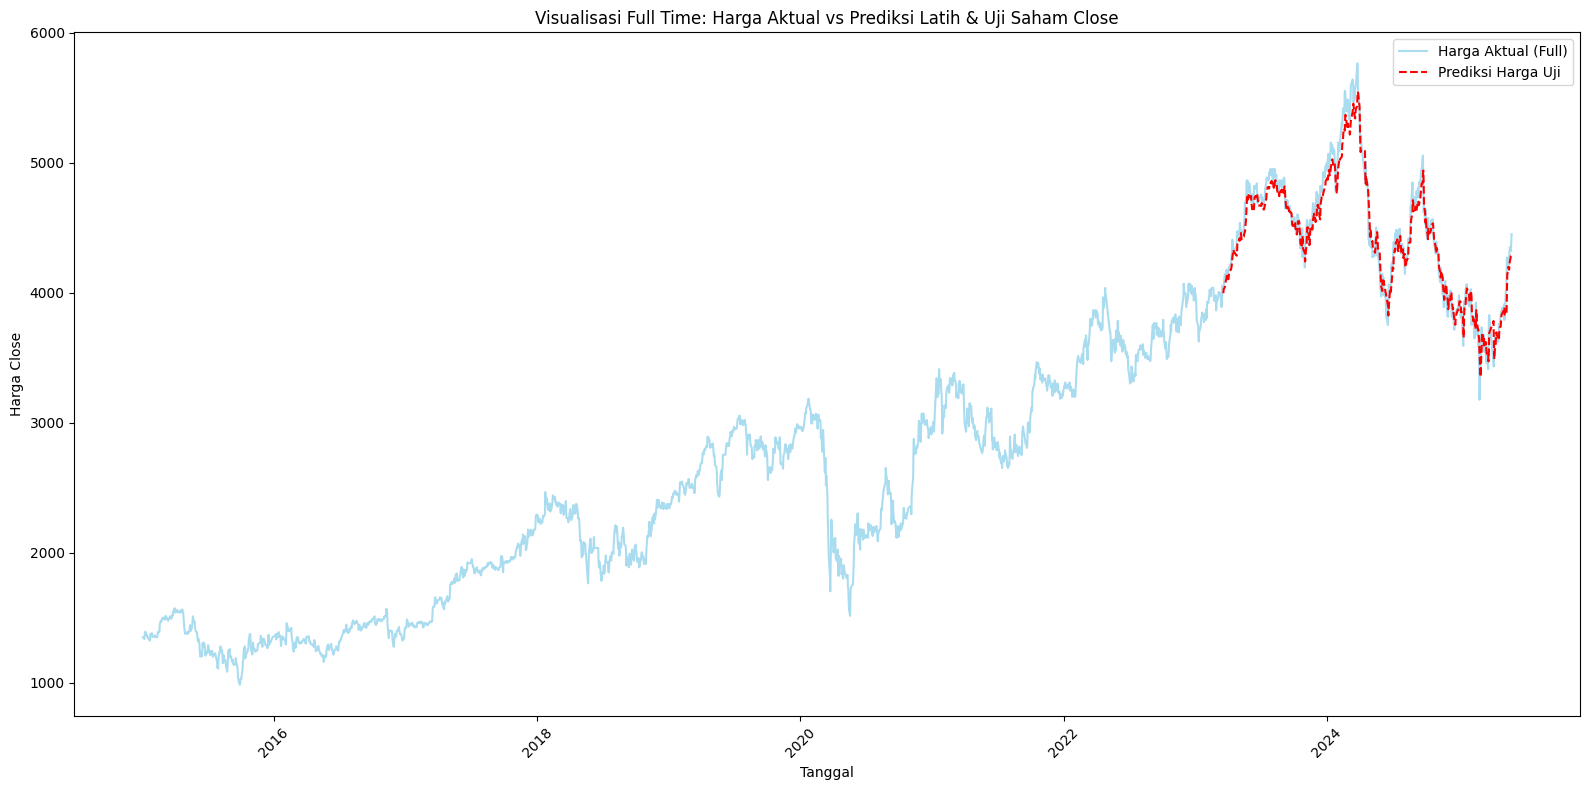

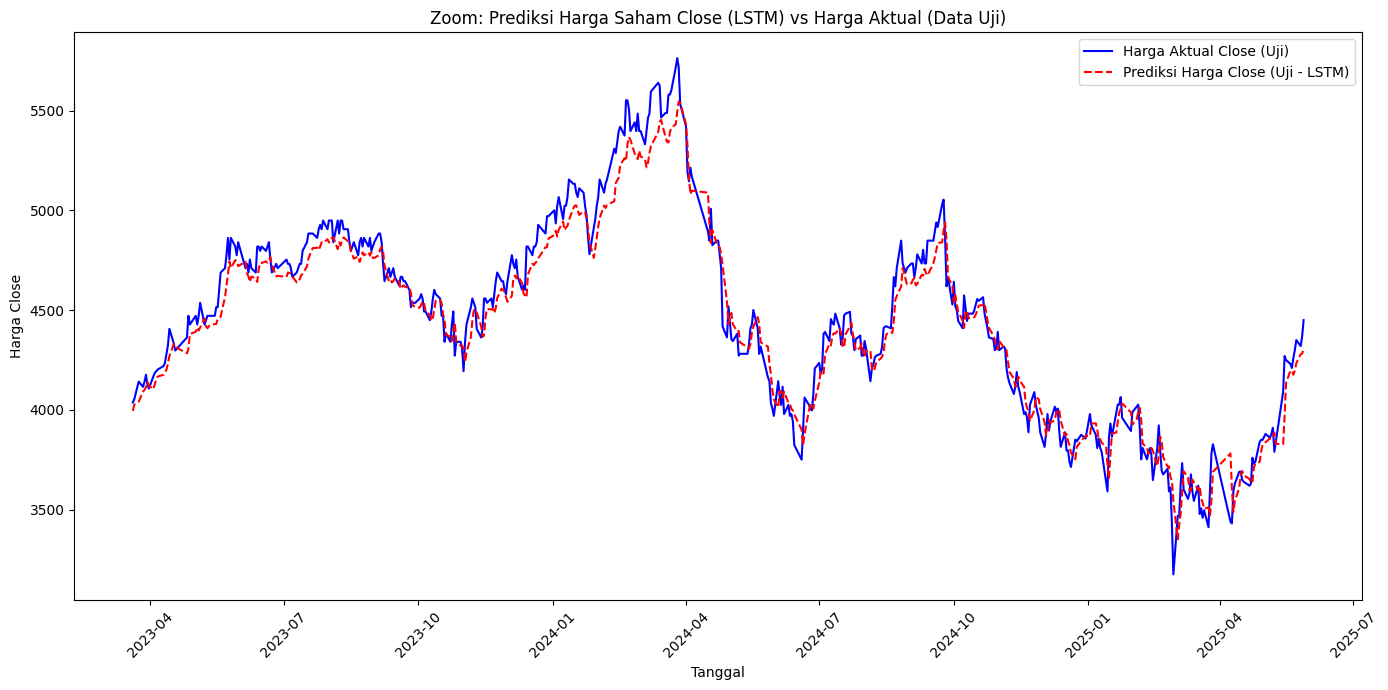

--- Memulai Pipeline Pelatihan Model Final ---

1. Persiapan Data (Menggunakan 100% Data)...
Bentuk data latih (100%): X_train: (2536, 30, 1), y_train: (2536,)
Persiapan data selesai.

2. Pembangunan Model LSTM...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,351 (1.70 MB)

 Trainable params: 445,351 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

Model LSTM berhasil dibangun.

3. Memulai pelatihan model dengan 100% data...
Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0423
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0038
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0034
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0028
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0029
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0029
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0027
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0021
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0023
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0021
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0018
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0016
Epoch 13/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0016
Epoch 14/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms

In [18]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= jalankan_pipeline_lstm(
    df_input=df,
    target_column='Close',
    time_steps=30,
    train_split_ratio=0.8,
    lstm_units_list=[100, 100,100,100,100,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=100,
    batch_size=32,
    nama=36,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

# RNN

In [32]:
def create_rnn_model_pipeline(
    df_input,
    target_column='Close',
    time_steps=60,
    train_split_ratio=0.8,
    rnn_units_list=[50, 50], 
    dense_units_list=[25],
    dropout_rate=0.2,
    optimizer='adam',
    loss_function='mean_squared_error',
    epochs=50,
    batch_size=32,
    verbose_level=1,
    nama=2,
    show_plots=True
    ):

    print("--- Memulai Pipeline Model RNN ---") 
    data_target = df_input.loc[:, [target_column]]
    dataset = data_target.values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    training_data_len = math.ceil(len(dataset) * train_split_ratio)
    train_data_scaled = scaled_data[0:training_data_len, :]

    X_train = []
    y_train = []
    for i in range(time_steps, len(train_data_scaled)):
        X_train.append(train_data_scaled[i-time_steps:i, 0])
        y_train.append(train_data_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print(f"Bentuk data latih X_train: {X_train.shape}, y_train (scaled): {y_train.shape}")

    test_data_scaled = scaled_data[training_data_len - time_steps:, :]
    X_test = []
    y_test_actual_unscaled = dataset[training_data_len:, :]

    for i in range(time_steps, len(test_data_scaled)):
        X_test.append(test_data_scaled[i-time_steps:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test_for_validation = []
    for i in range(time_steps, len(test_data_scaled)):
        y_test_for_validation.append(test_data_scaled[i,0])
    y_test_for_validation = np.array(y_test_for_validation)
    print("Persiapan data selesai.")


    model = Sequential()
    if len(rnn_units_list) > 1:
        # Lapisan RNN pertama
        model.add(SimpleRNN(units=rnn_units_list[0], return_sequences=True, input_shape=(X_train.shape[1], 1))) # Menggunakan SimpleRNN
        model.add(Dropout(dropout_rate))
        # Lapisan RNN berikutnya
        for i in range(1, len(rnn_units_list)):
            is_last_rnn_layer = (i == len(rnn_units_list) - 1)
            model.add(SimpleRNN(units=rnn_units_list[i], return_sequences=not is_last_rnn_layer)) # Menggunakan SimpleRNN
            model.add(Dropout(dropout_rate))
    elif len(rnn_units_list) == 1:
        # Hanya satu lapisan RNN
        model.add(SimpleRNN(units=rnn_units_list[0], return_sequences=False, input_shape=(X_train.shape[1], 1))) # Menggunakan SimpleRNN
        model.add(Dropout(dropout_rate))
    else:
        raise ValueError("rnn_units_list tidak boleh kosong.")

    # Lapisan Dense
    for units in dense_units_list:
        model.add(Dense(units=units))
    model.add(Dense(units=1)) # Lapisan output

    # Kompilasi model
    model.compile(optimizer=optimizer, loss=loss_function)
    print("Ringkasan Model:")
    model.summary()
    print("Model RNN berhasil dibangun.") # Diubah ke RNN

    # 3. Latih Model
    print("\n3. Memulai pelatihan model...")
    start_time = time.time()
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test_for_validation),
                        verbose=verbose_level)
    end_time = time.time()
    training_time = end_time - start_time
    print("Pelatihan model selesai.")
    print(f"Waktu pelatihan model: {training_time:.2f} detik")

    # 4. Buat Prediksi
    print("\n4a. Membuat prediksi pada data latih (untuk visualisasi)...")
    train_predictions_scaled = model.predict(X_train)
    train_predictions_unscaled = scaler.inverse_transform(train_predictions_scaled)

    print("4b. Membuat prediksi pada data uji...")
    test_predictions_scaled = model.predict(X_test)
    test_predictions_unscaled = scaler.inverse_transform(test_predictions_scaled)
    print("Prediksi selesai.")


    # 5. Evaluasi Model (menggunakan data uji)
    print("\n5. Mengevaluasi model (pada data uji)...")
    rmse = np.sqrt(mean_squared_error(y_test_actual_unscaled, test_predictions_unscaled))
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

    y_test_flat = y_test_actual_unscaled.flatten()
    predictions_flat = test_predictions_unscaled.flatten()
    non_zero_mask = y_test_flat != 0
    if np.any(non_zero_mask):
        mape = mean_absolute_percentage_error(y_test_flat[non_zero_mask], predictions_flat[non_zero_mask]) * 100
        print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    else:
        mape = float('inf')
        print('MAPE tidak dapat dihitung karena semua nilai aktual adalah nol atau tidak ada nilai non-zero.')


    # 1. Buat DataFrame untuk plot, berisi harga aktual
    df_plot = pd.DataFrame(df_input[target_column])
    df_plot.rename(columns={target_column: 'Harga_Aktual'}, inplace=True)
    test_predict_index = df_input.index[training_data_len : training_data_len + len(test_predictions_unscaled)]
    df_predictions = pd.DataFrame(test_predictions_unscaled, index=test_predict_index, columns=['Prediksi_Uji'])
    df_final_plot = df_plot.join(df_predictions)
    csv_filename = f'RNN_{nama}_{epochs}.csv'
    df_final_plot.to_csv(csv_filename)
    

    
    # 1. Buat sebuah dictionary untuk menyimpan metrik
    metrik_evaluasi = {
        "RMSE": rmse,
        "MAPE": mape
    }
    json_filename = f'eval_RNN_{nama}_{epochs}.json'
    with open(json_filename, 'w') as f:
        json.dump(metrik_evaluasi, f, indent=4)
        
    print(f"Metrik evaluasi berhasil disimpan sebagai '{json_filename}'")



    if show_plots:
        print("\n6. Visualisasi Hasil...")
        plt.figure(figsize=(16, 8))
        plt.title(f'Visualisasi Full Time: Harga Aktual vs Prediksi Latih & Uji Saham {target_column} (RNN)') # Diubah ke RNN
        plt.xlabel('Tanggal')
        plt.ylabel(f'Harga {target_column}')
        plt.plot(df_input.index, dataset, color='skyblue', alpha=0.7, label='Harga Aktual (Full)')

        # Indeks untuk plot prediksi latih (jika ingin ditampilkan)
        # train_predict_plot_index = df_input.index[time_steps : time_steps + len(train_predictions_unscaled)]
        # plt.plot(train_predict_plot_index, train_predictions_unscaled, color='orange', linestyle='--', label='Prediksi Harga Latih (RNN)')

        # Indeks untuk plot prediksi uji
        test_predict_index = df_input.index[training_data_len : training_data_len + len(test_predictions_unscaled)]
        plt.plot(test_predict_index, test_predictions_unscaled, color='red', linestyle='--', label='Prediksi Harga Uji (RNN)') # Diubah ke RNN

        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(14, 7))
        actual_plot_index_test = df_input.index[training_data_len : training_data_len + len(y_test_actual_unscaled)]
        min_len_test_plot = min(len(y_test_actual_unscaled), len(test_predictions_unscaled))

        plt.plot(actual_plot_index_test[:min_len_test_plot], y_test_actual_unscaled[:min_len_test_plot], color='blue', label=f'Harga Aktual {target_column} (Uji)')
        plt.plot(actual_plot_index_test[:min_len_test_plot], test_predictions_unscaled[:min_len_test_plot], color='red', linestyle='--', label=f'Prediksi Harga {target_column} (Uji - RNN)') # Diubah ke RNN
        plt.title(f'Zoom: Prediksi Harga Saham {target_column} (RNN) vs Harga Aktual (Data Uji)') # Diubah ke RNN
        plt.xlabel('Tanggal')
        plt.ylabel(f'Harga {target_column}')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    tf.keras.backend.clear_session()
    atur_seed_deterministik(42)
    final_model, final_scaler = train_rnn_final_model(
    df_input=df_input,                 
    target_column='Close',             
    time_steps=time_steps,
    rnn_units_list=rnn_units_list,
    dense_units_list=dense_units_list,
    dropout_rate=dropout_rate,
    optimizer=optimizer,
    loss_function=loss_function,
    epochs=epochs,
    batch_size=batch_size,                      
    save_filename_prefix=f'RNN_{nama}_{epochs}' )
    print("\n--- Pipeline Model RNN Selesai ---")
    return model, history, rmse, mape, scaler,final_model, final_scaler


def train_rnn_final_model(
    df_input,
    target_column='Close',
    time_steps=60,
    rnn_units_list=[50, 50],
    dense_units_list=[25],
    dropout_rate=0.2,
    optimizer='adam',
    loss_function='mean_squared_error',
    epochs=50,
    batch_size=32,
    verbose_level=1,
    save_filename_prefix='model_final_rnn'
    ):

    data_target = df_input.loc[:, [target_column]]
    dataset = data_target.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    X_train_full = []
    y_train_full = []
    for i in range(time_steps, len(scaled_data)):
        X_train_full.append(scaled_data[i-time_steps:i, 0])
        y_train_full.append(scaled_data[i, 0])
        
    X_train_full, y_train_full = np.array(X_train_full), np.array(y_train_full)
    X_train_full = np.reshape(X_train_full, (X_train_full.shape[0], X_train_full.shape[1], 1))


    print("\n2. Pembangunan Model RNN...")
    model = Sequential()
    if len(rnn_units_list) > 1:
        model.add(SimpleRNN(units=rnn_units_list[0], return_sequences=True, input_shape=(X_train_full.shape[1], 1)))
        model.add(Dropout(dropout_rate))
        for i in range(1, len(rnn_units_list)):
            is_last_rnn_layer = (i == len(rnn_units_list) - 1)
            model.add(SimpleRNN(units=rnn_units_list[i], return_sequences=not is_last_rnn_layer))
            model.add(Dropout(dropout_rate))
    elif len(rnn_units_list) == 1:
        model.add(SimpleRNN(units=rnn_units_list[0], return_sequences=False, input_shape=(X_train_full.shape[1], 1)))
        model.add(Dropout(dropout_rate))
    else:
        raise ValueError("rnn_units_list tidak boleh kosong.")
        
    for units in dense_units_list:
        model.add(Dense(units=units))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss=loss_function)
    model.summary()

    model.fit(X_train_full, y_train_full,
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose_level)
    print("Pelatihan model selesai.")

    print("\n4. Menyimpan model dan scaler...")
    model_filename = f"{save_filename_prefix}.keras"
    scaler_filename = f"{save_filename_prefix}_scaler.pkl"
    model.save(model_filename)
    joblib.dump(scaler, scaler_filename)
    print(f"Model sebagai '{model_filename}' dan scaler sebagai '{scaler_filename}' berhasil disimpan.")

    print("\n--- Pipeline Pelatihan Model Final RNN Selesai ---")
    return model, scaler



In [33]:
tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model RNN ---
Bentuk data latih X_train: (1993, 60, 1), y_train (scaled): (1993,)
Persiapan data selesai.
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,951 (34.96 KB)

 Trainable params: 8,951 (34.96 KB)

 Non-trainable params: 0 (0.00 B)

Model RNN berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0507 - val_loss: 0.0013
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 8.2335e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.2506e-04 - val_loss: 0.0024
Epo

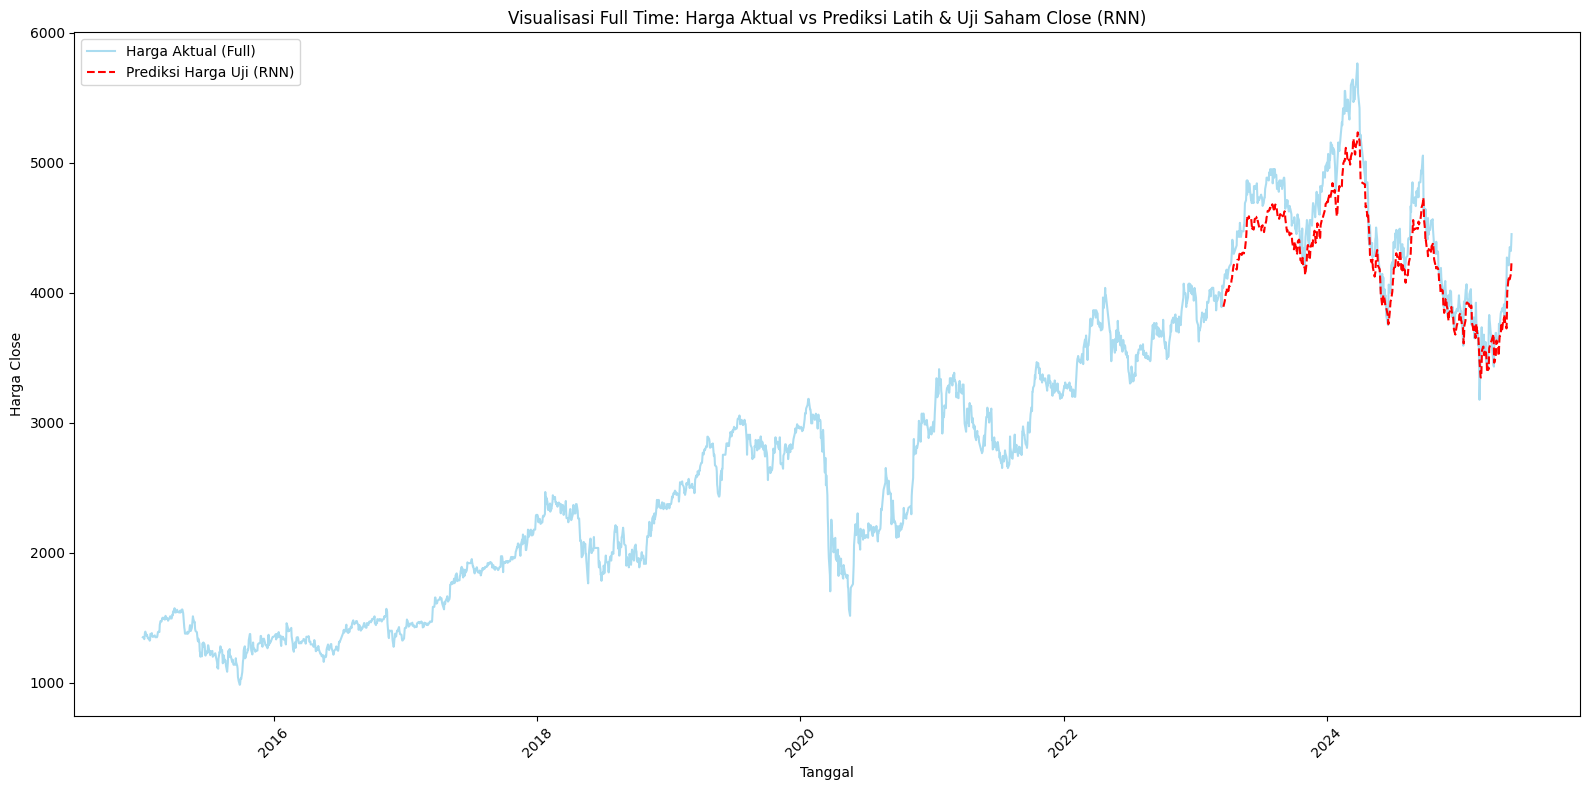

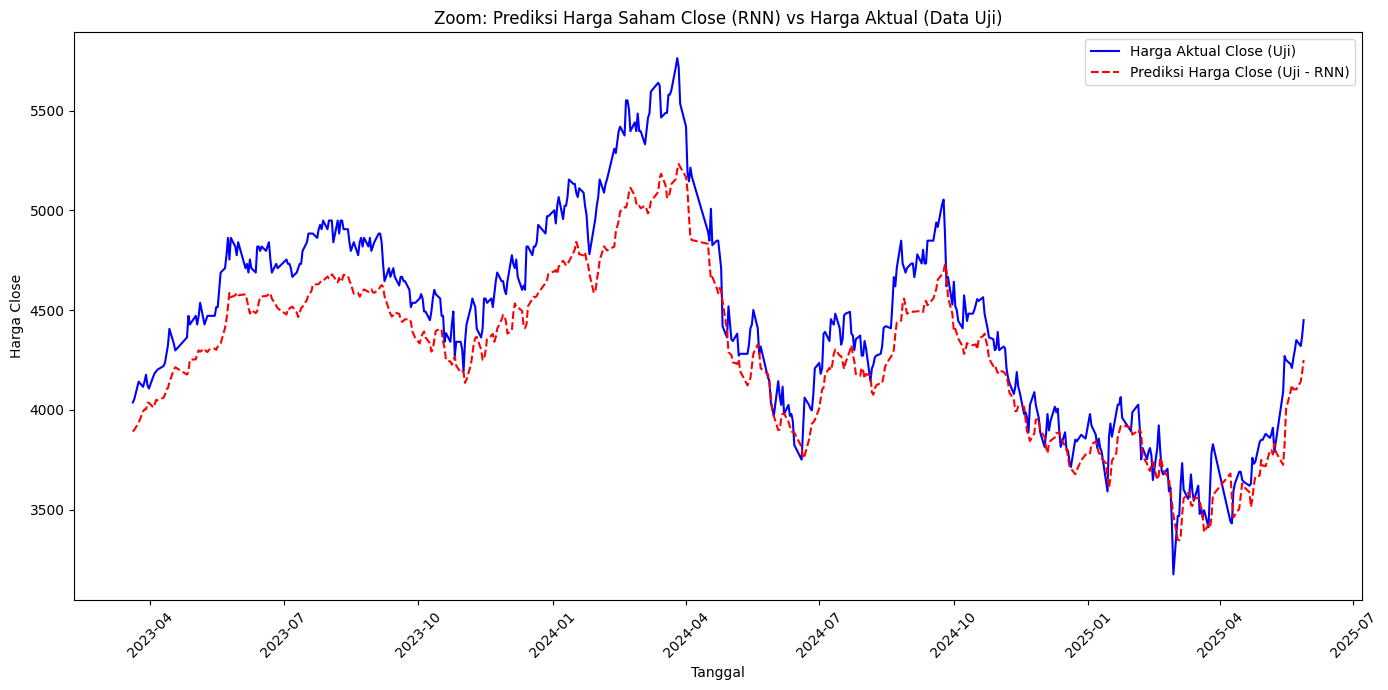


2. Pembangunan Model RNN...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,951 (34.96 KB)

 Trainable params: 8,951 (34.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0586
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010   
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 15/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011
Epoch 16/50

In [21]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= create_rnn_model_pipeline(
    df_input=df,
    target_column='Close',
    time_steps=60,
    train_split_ratio=0.8,
    rnn_units_list=[50,50],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=50,
    batch_size=32,
    nama=62,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model RNN ---
Bentuk data latih X_train: (1993, 60, 1), y_train (scaled): (1993,)
Persiapan data selesai.
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,951 (34.96 KB)

 Trainable params: 8,951 (34.96 KB)

 Non-trainable params: 0 (0.00 B)

Model RNN berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0507 - val_loss: 0.0013
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - val_loss: 8.2335e-04
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.2506e-04 - val

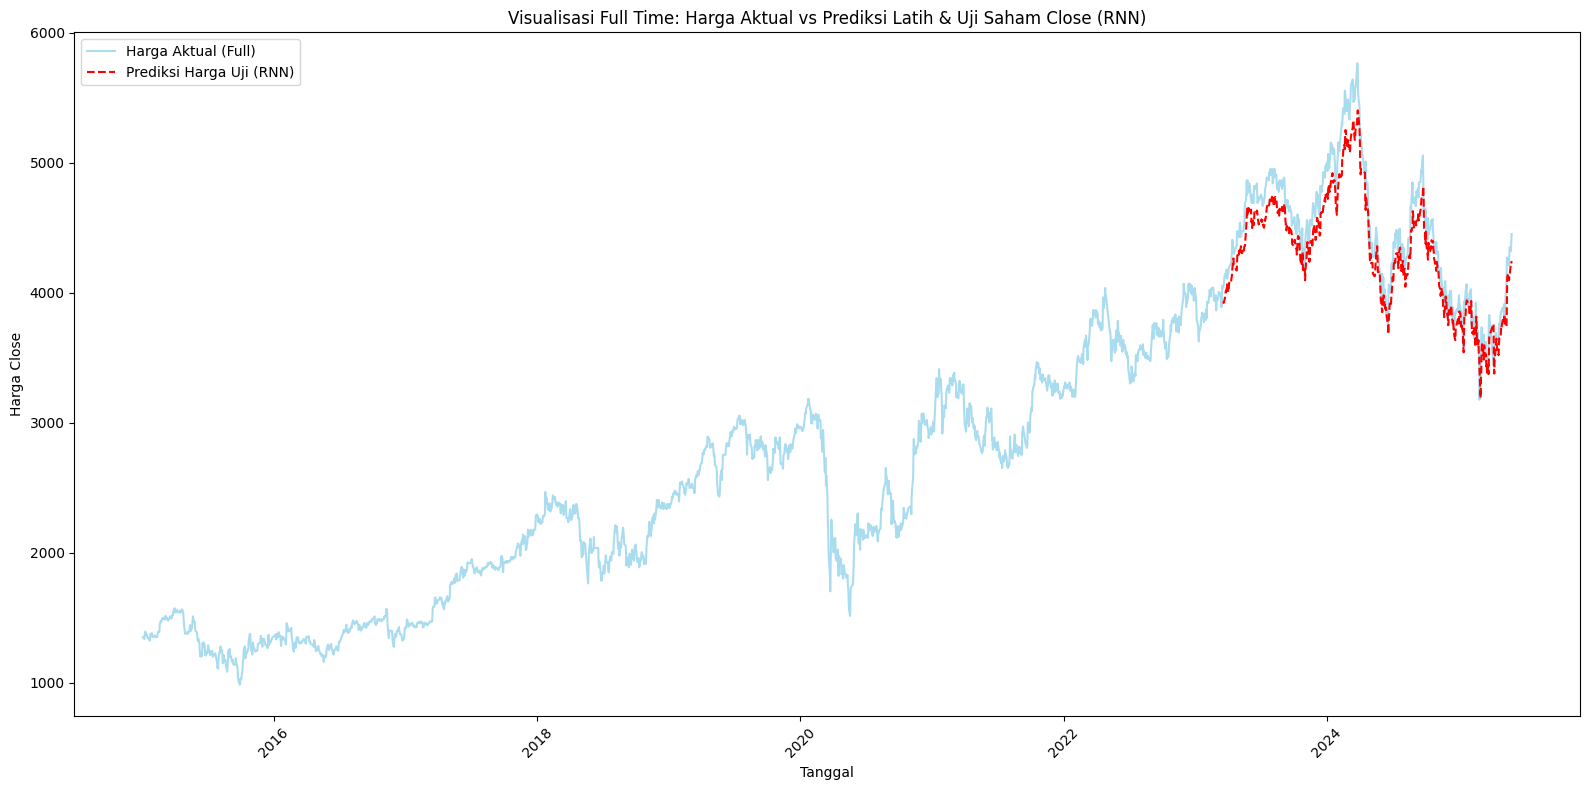

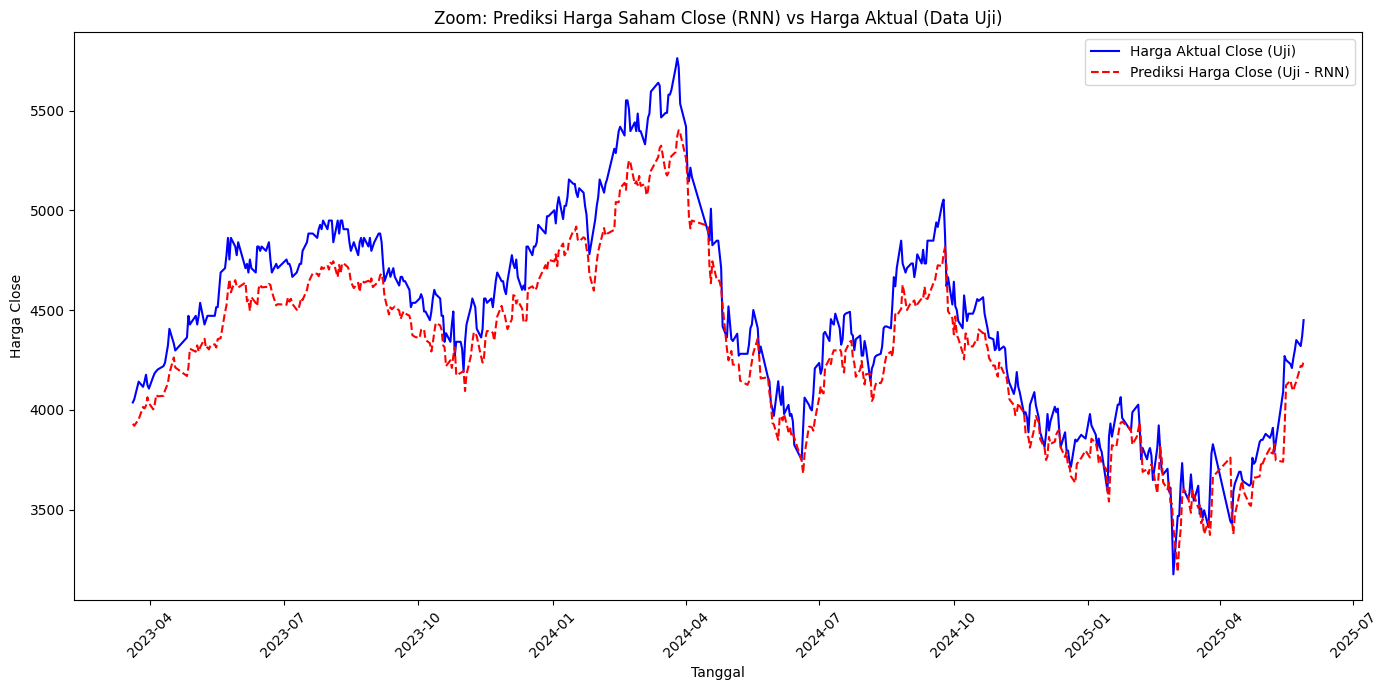


2. Pembangunan Model RNN...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,951 (34.96 KB)

 Trainable params: 8,951 (34.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0586
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0071
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011
Epoch 13/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010    
Epoch 14/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011
Epoch 15/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011


In [22]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= create_rnn_model_pipeline(
    df_input=df,
    target_column='Close',
    time_steps=60,
    train_split_ratio=0.8,
    rnn_units_list=[50,50],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=100,
    batch_size=32,
    nama=62,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model RNN ---
Bentuk data latih X_train: (1993, 60, 1), y_train (scaled): (1993,)
Persiapan data selesai.
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,251 (79.11 KB)

 Trainable params: 20,251 (79.11 KB)

 Non-trainable params: 0 (0.00 B)

Model RNN berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0906 - val_loss: 0.0019
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0082 - val_loss: 0.0015
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 8.0876e-04
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.8368e-04 - val_loss: 0.

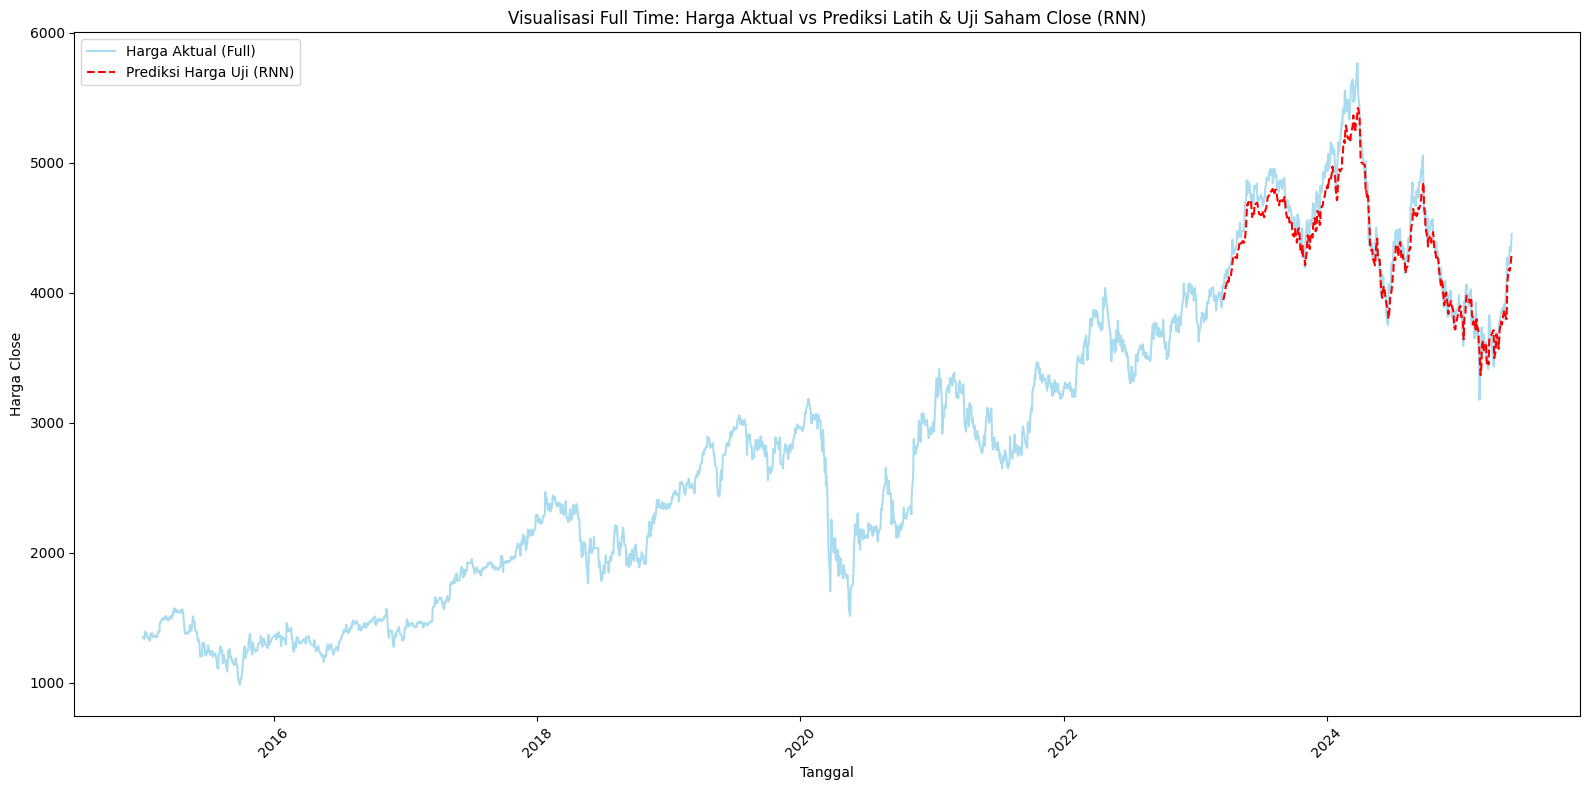

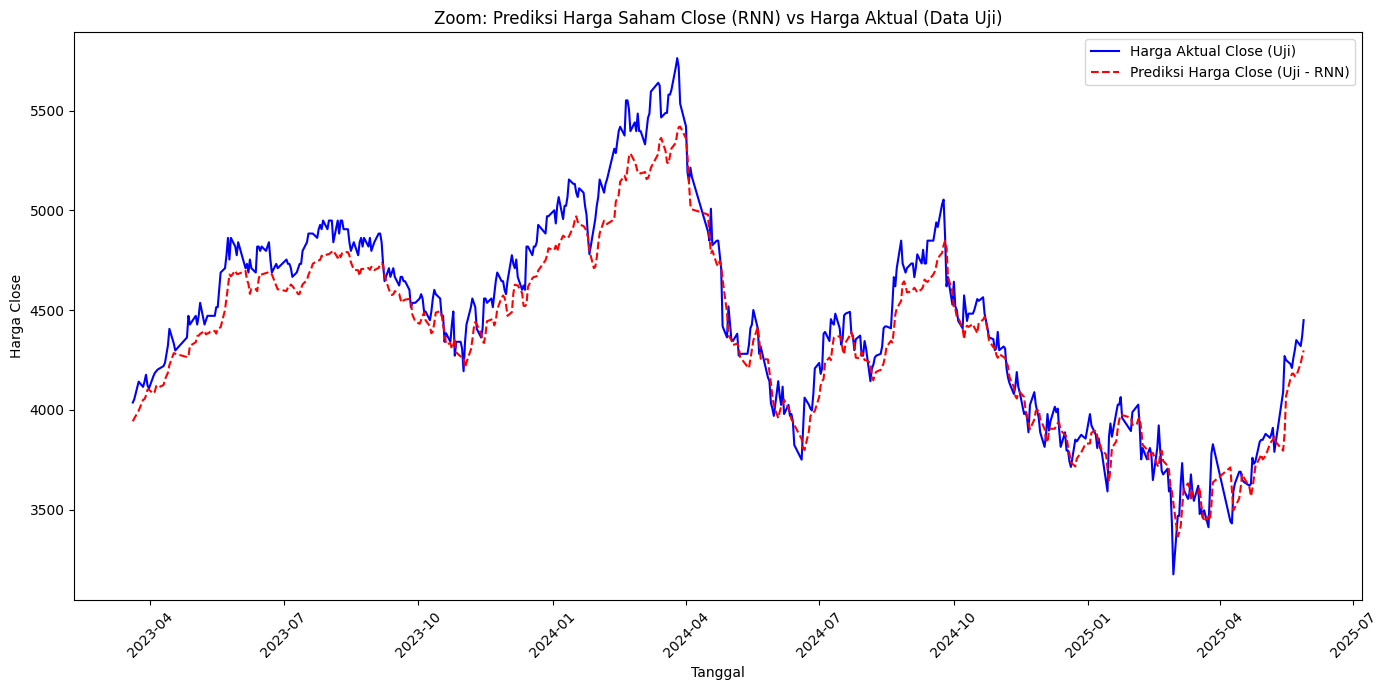


2. Pembangunan Model RNN...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,251 (79.11 KB)

 Trainable params: 20,251 (79.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1015
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0094
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013
Epoch 15/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013
Epoch 16/50
79/7

In [23]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= create_rnn_model_pipeline(
    df_input=df,
    target_column='Close',
    time_steps=60,
    train_split_ratio=0.8,
    rnn_units_list=[50,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=50,
    batch_size=32,
    nama=63,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model RNN ---
Bentuk data latih X_train: (1993, 60, 1), y_train (scaled): (1993,)
Persiapan data selesai.
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,251 (79.11 KB)

 Trainable params: 20,251 (79.11 KB)

 Non-trainable params: 0 (0.00 B)

Model RNN berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0906 - val_loss: 0.0019
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0082 - val_loss: 0.0015
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - val_loss: 8.0876e-04
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.8368e-04 - v

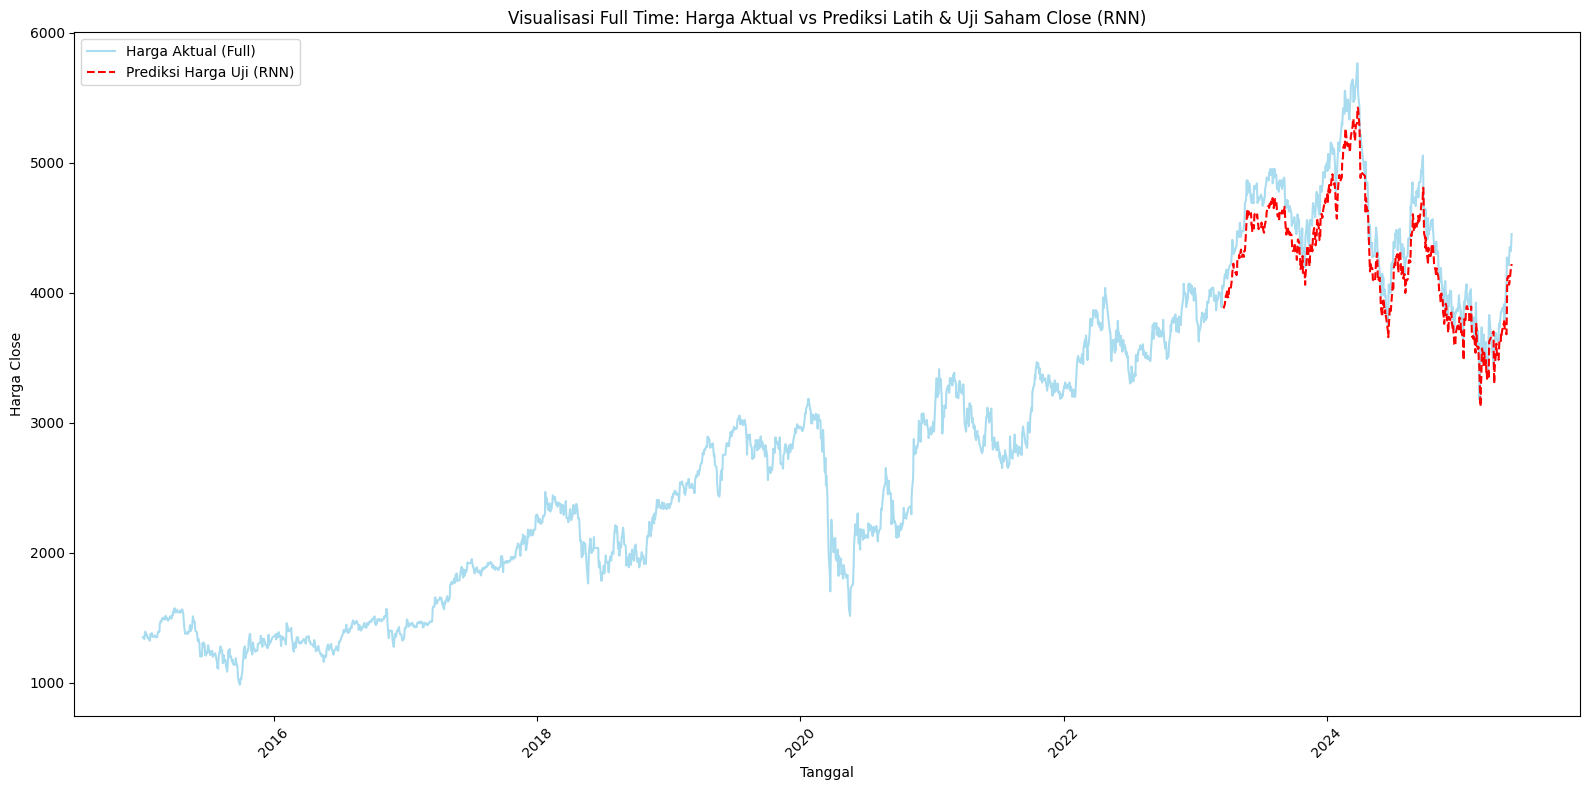

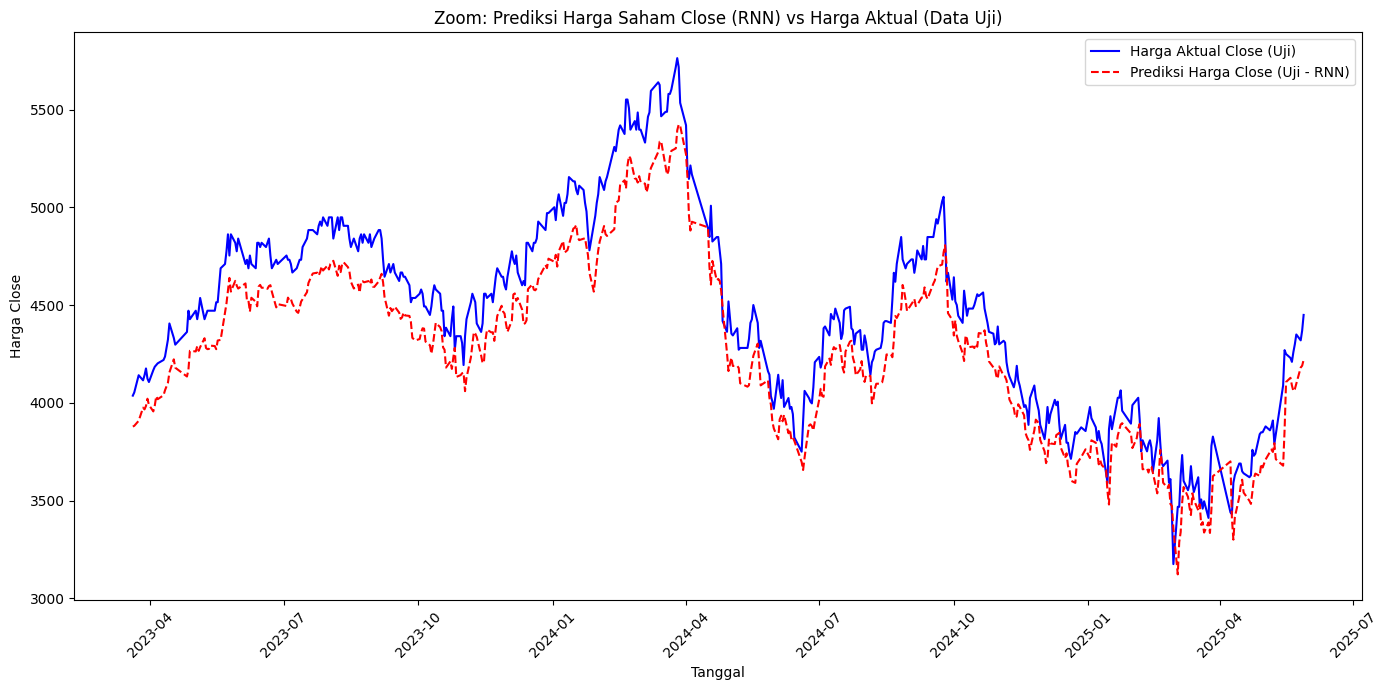


2. Pembangunan Model RNN...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,251 (79.11 KB)

 Trainable params: 20,251 (79.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1015
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0094
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013
Epoch 13/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012
Epoch 14/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013
Epoch 15/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013

In [24]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= create_rnn_model_pipeline(
    df_input=df,
    target_column='Close',
    time_steps=60,
    train_split_ratio=0.8,
    rnn_units_list=[50,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=100,
    batch_size=32,
    nama=63,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model RNN ---
Bentuk data latih X_train: (2023, 30, 1), y_train (scaled): (2023,)
Persiapan data selesai.
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,951 (34.96 KB)

 Trainable params: 8,951 (34.96 KB)

 Non-trainable params: 0 (0.00 B)

Model RNN berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0470 - val_loss: 0.0052
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - val_loss: 0.0023
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - val_loss: 0.0063
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8057e-04 - val_loss: 0.0024
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9277e-04 - val_loss: 0.0028
Epoch

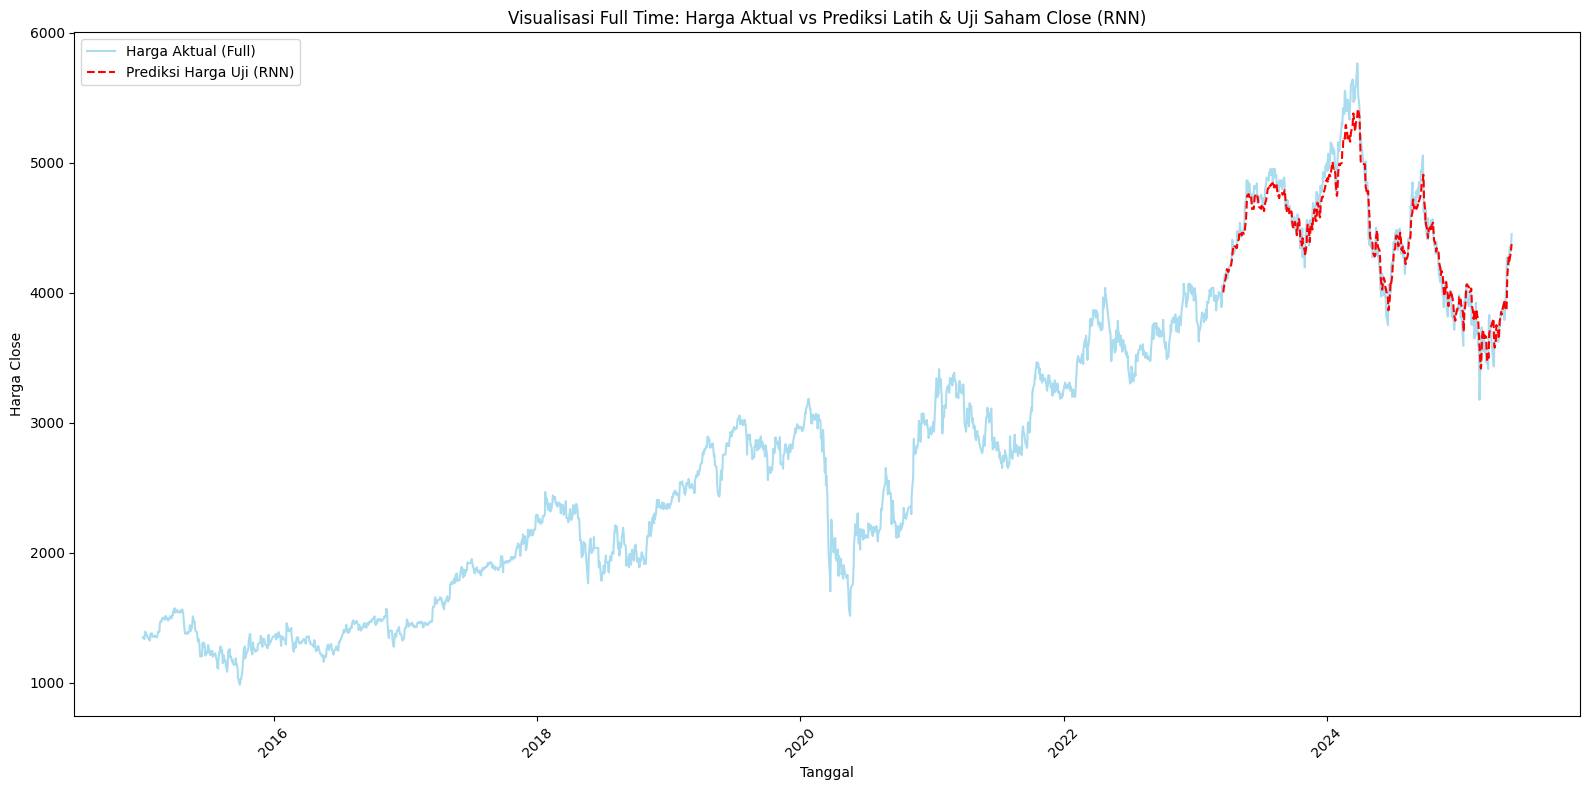

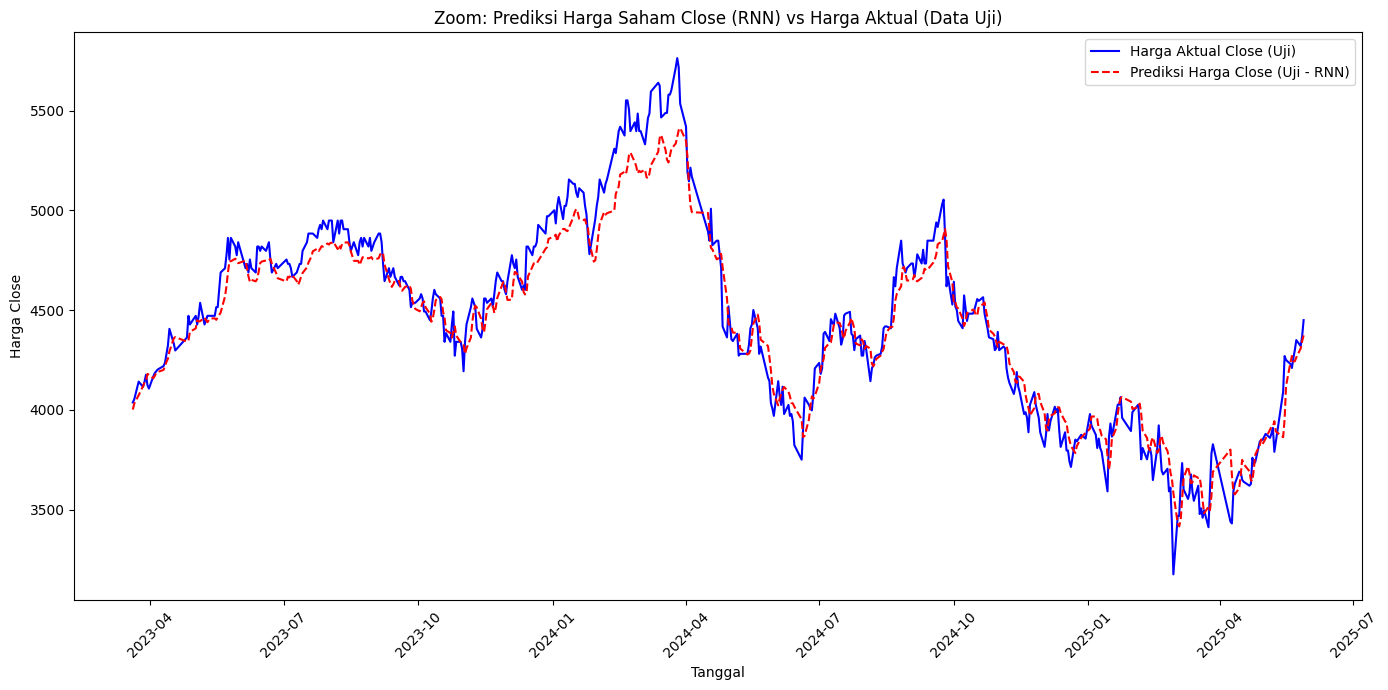


2. Pembangunan Model RNN...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,951 (34.96 KB)

 Trainable params: 8,951 (34.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0542
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0078
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 13/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 14/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 15/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 16/50
80/80 ━

In [25]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= create_rnn_model_pipeline(
    df_input=df,
    target_column='Close',
    time_steps=30,
    train_split_ratio=0.8,
    rnn_units_list=[50,50],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=50,
    batch_size=32,
    nama=32,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model RNN ---
Bentuk data latih X_train: (2023, 30, 1), y_train (scaled): (2023,)
Persiapan data selesai.
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,951 (34.96 KB)

 Trainable params: 8,951 (34.96 KB)

 Non-trainable params: 0 (0.00 B)

Model RNN berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0470 - val_loss: 0.0052
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - val_loss: 0.0023
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - val_loss: 0.0063
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8057e-04 - val_loss: 0.0024
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9277e-04 - val_loss: 0

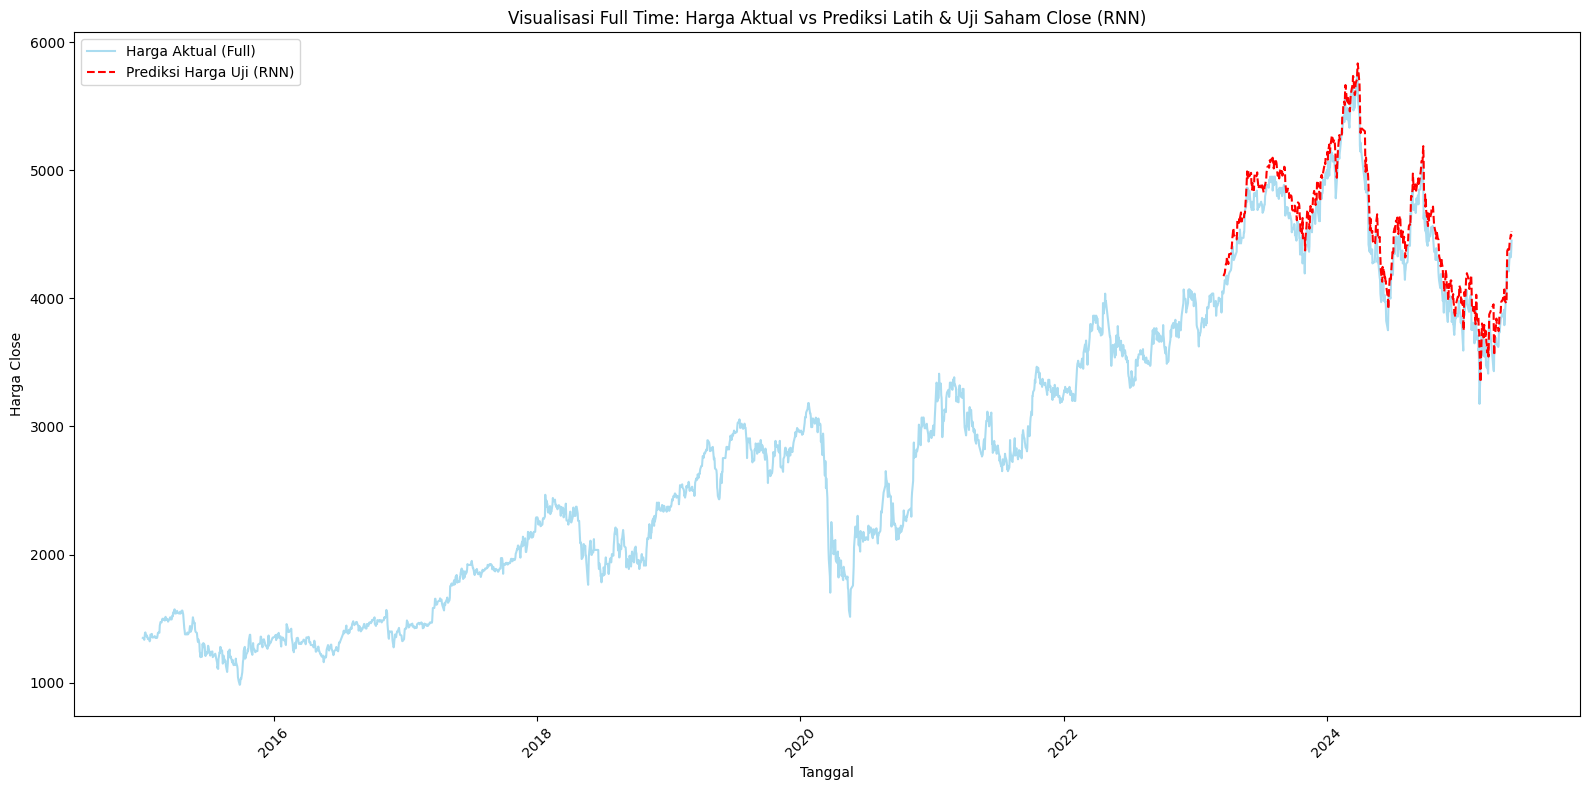

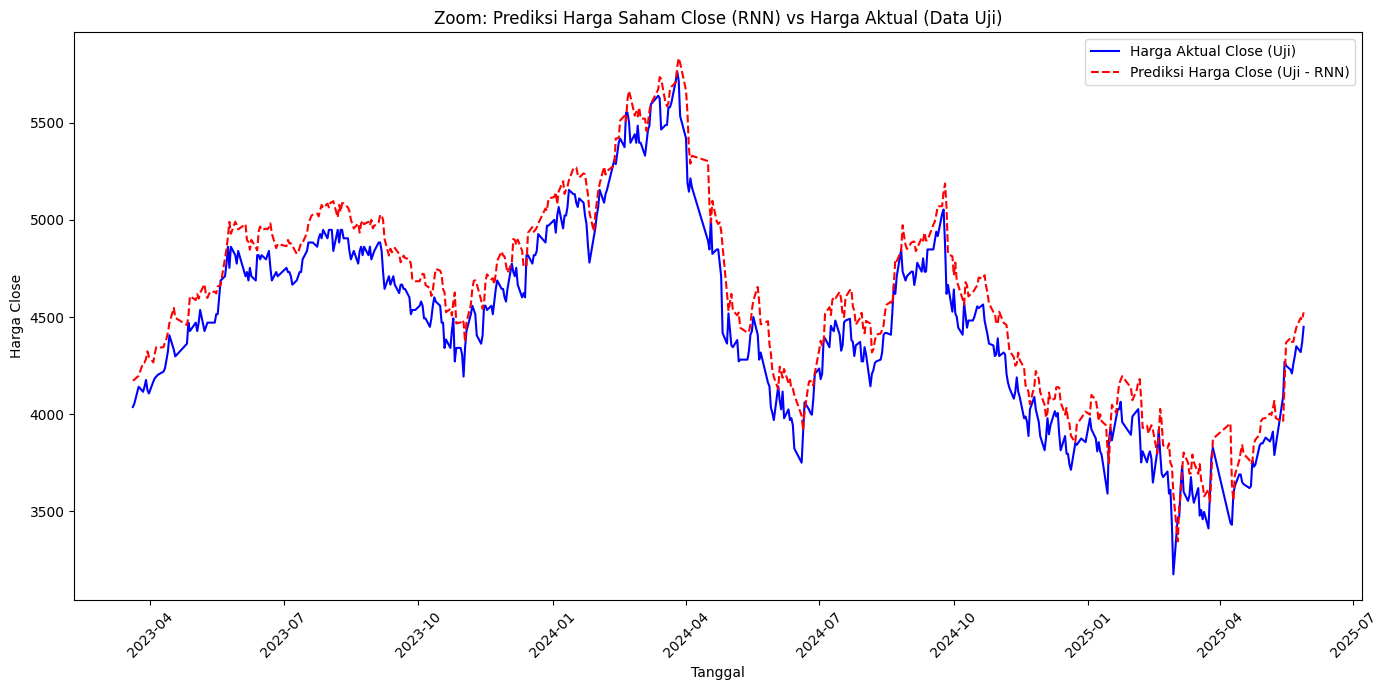


2. Pembangunan Model RNN...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,951 (34.96 KB)

 Trainable params: 8,951 (34.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0542
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 13/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 14/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 15/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoc

In [26]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= create_rnn_model_pipeline(
    df_input=df,
    target_column='Close',
    time_steps=30,
    train_split_ratio=0.8,
    rnn_units_list=[50,50],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=100,
    batch_size=32,
    nama=32,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model RNN ---
Bentuk data latih X_train: (2023, 30, 1), y_train (scaled): (2023,)
Persiapan data selesai.
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,251 (79.11 KB)

 Trainable params: 20,251 (79.11 KB)

 Non-trainable params: 0 (0.00 B)

Model RNN berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0912 - val_loss: 0.0025
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - val_loss: 7.0036e-04
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 6.5422e-04
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - val_loss: 7.8592e-04
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - val_loss: 7.4512e-

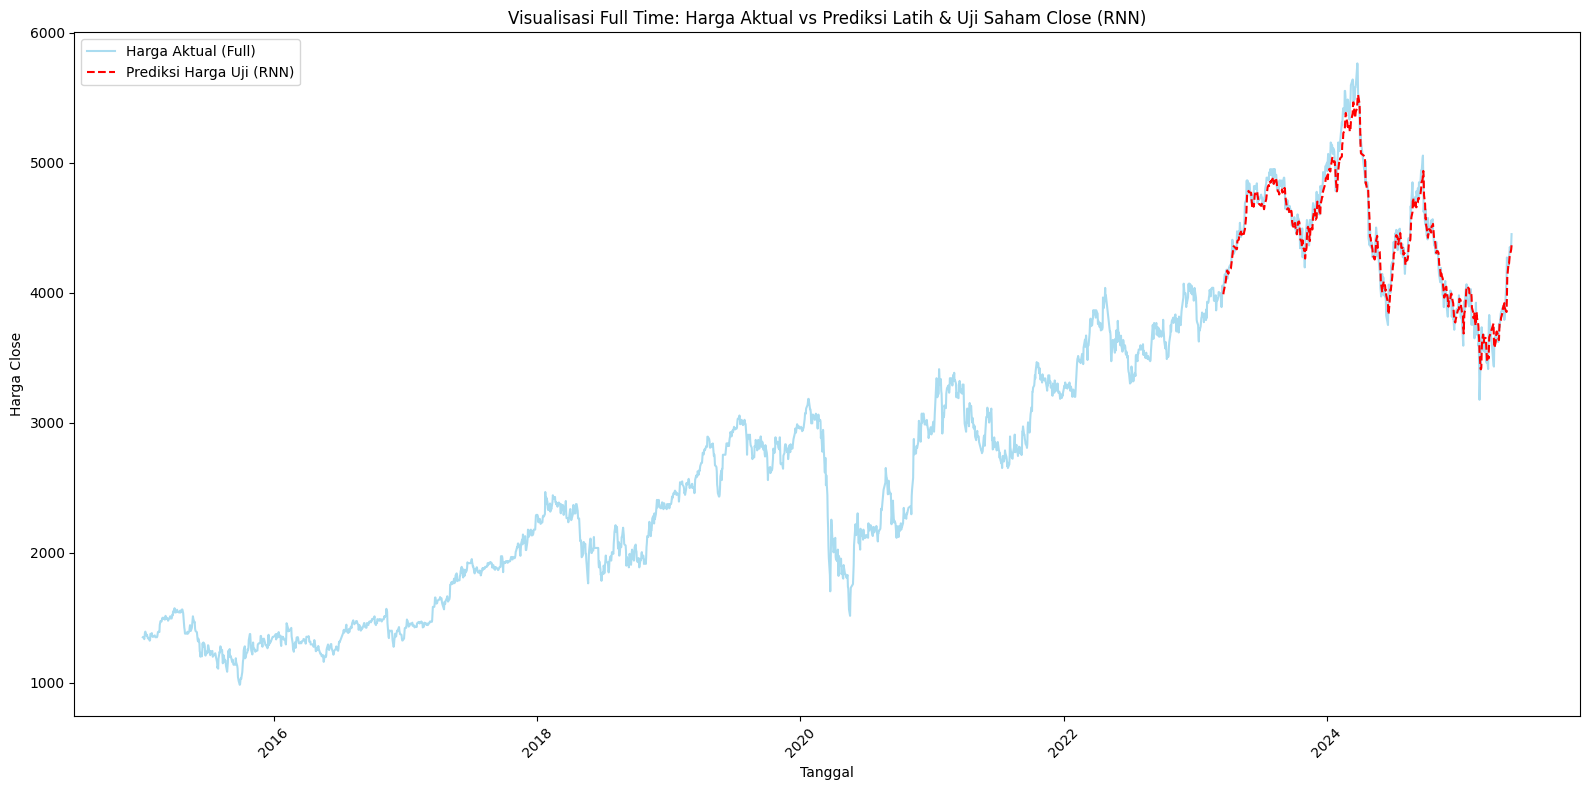

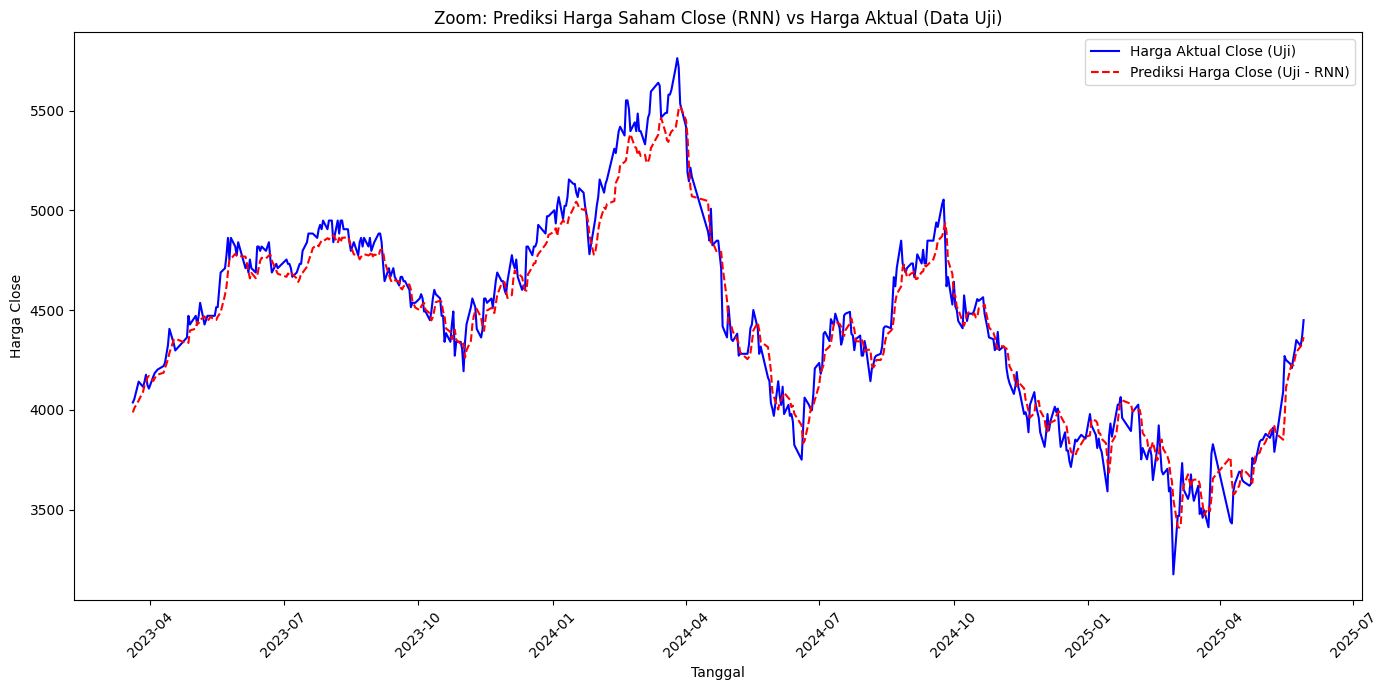


2. Pembangunan Model RNN...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,251 (79.11 KB)

 Trainable params: 20,251 (79.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0948
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0081
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0053
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015
Epoch 13/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
Epoch 14/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014
Epoch 15/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.7594e-04
Epoch 16/50
80/

In [34]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= create_rnn_model_pipeline(
    df_input=df,
    target_column='Close',
    time_steps=30,
    train_split_ratio=0.8,
    rnn_units_list=[50,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=50,
    batch_size=32,
    nama=33,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)

--- Memulai Pipeline Model RNN ---
Bentuk data latih X_train: (2023, 30, 1), y_train (scaled): (2023,)
Persiapan data selesai.
Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,251 (79.11 KB)

 Trainable params: 20,251 (79.11 KB)

 Non-trainable params: 0 (0.00 B)

Model RNN berhasil dibangun.

3. Memulai pelatihan model...
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0912 - val_loss: 0.0025
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - val_loss: 7.0036e-04
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 6.5422e-04
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 7.8592e-04
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_los

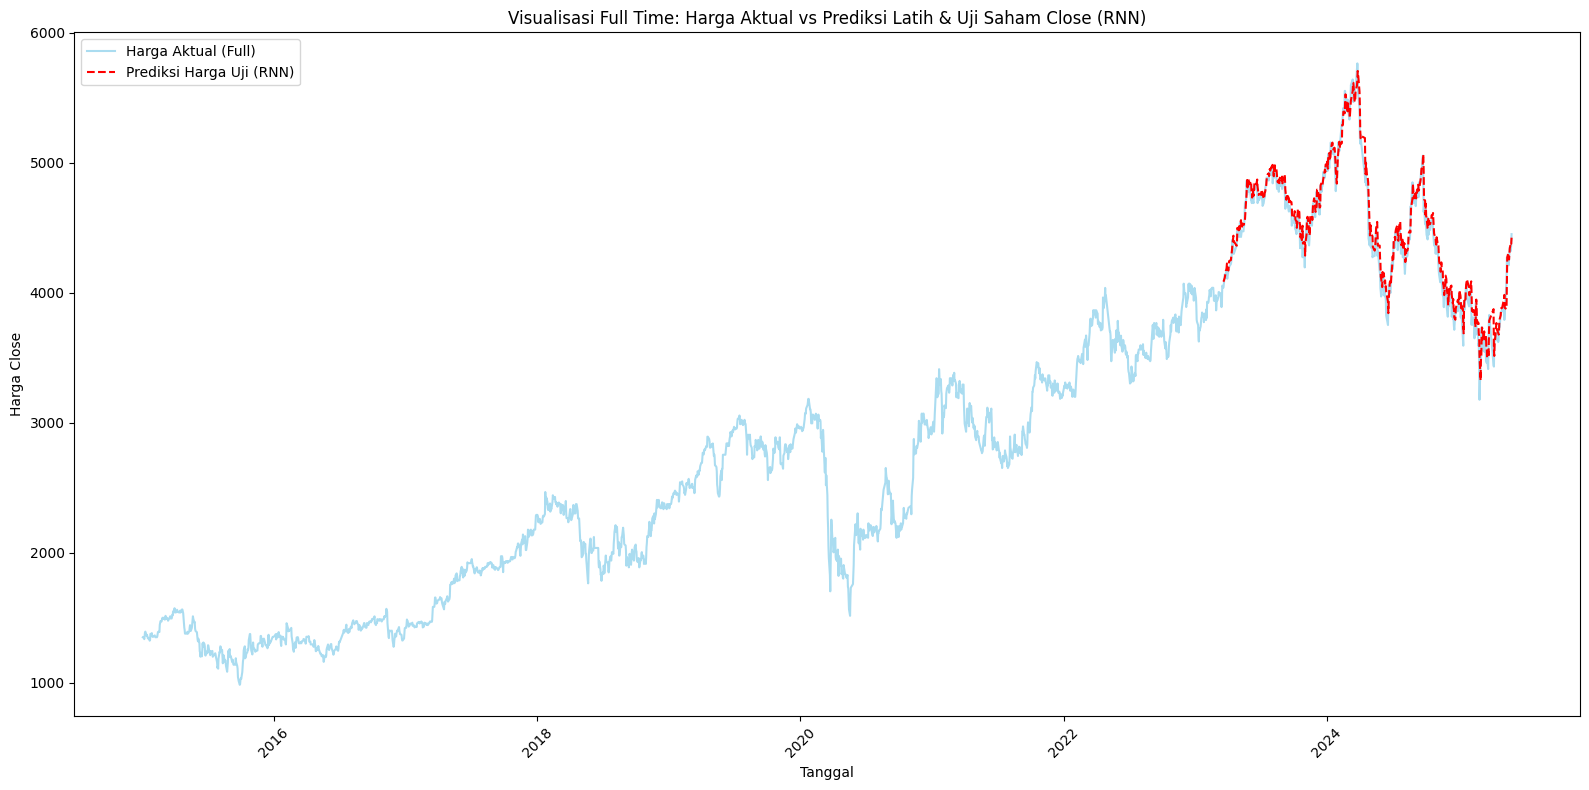

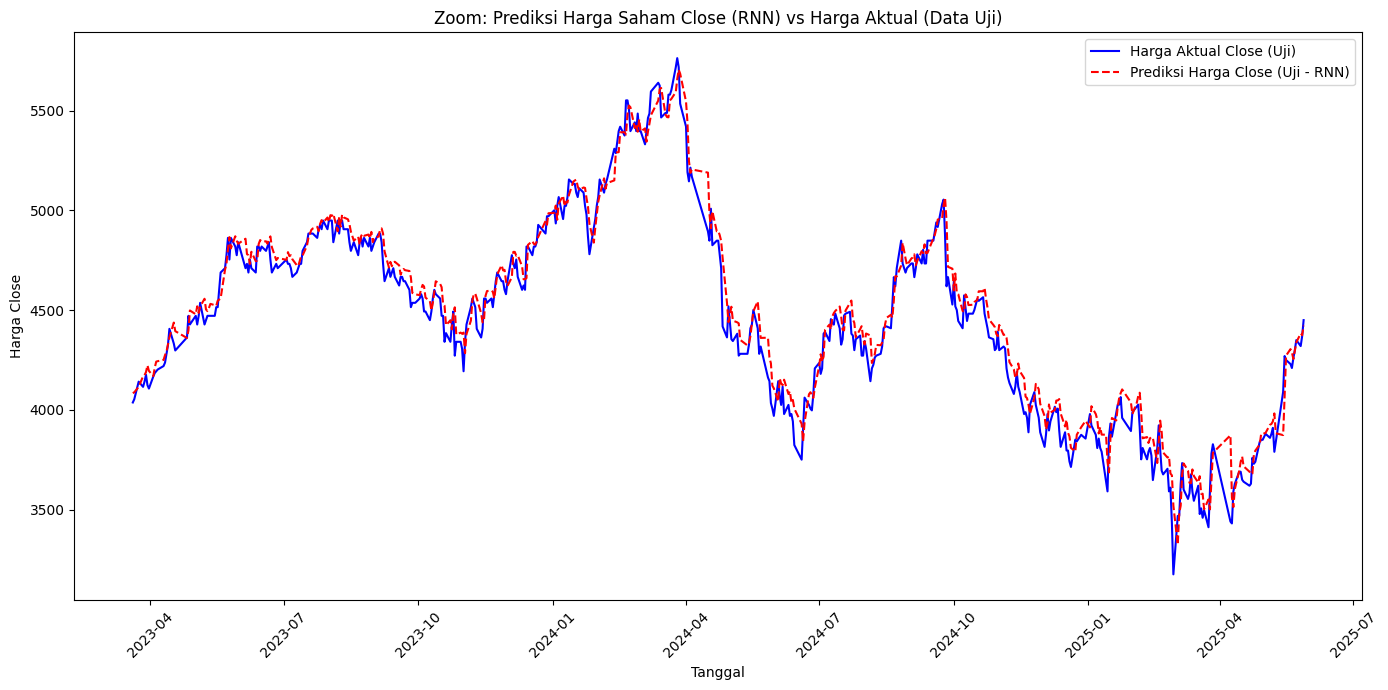


2. Pembangunan Model RNN...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,251 (79.11 KB)

 Trainable params: 20,251 (79.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0948
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015
Epoch 13/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 14/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014
Epoch 15/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.7594e-04


In [35]:
model_hasil_eval, history, rmse_hasil, mape_hasil, scaler_eval, model_final, scaler_final= create_rnn_model_pipeline(
    df_input=df,
    target_column='Close',
    time_steps=30,
    train_split_ratio=0.8,
    rnn_units_list=[50,100],
    dense_units_list=[25],
    dropout_rate=0.2,
    epochs=100,
    batch_size=32,
    nama=33,
    show_plots=True
)

tf.keras.backend.clear_session()
atur_seed_deterministik(42)